# Final Project Report - DAT650, Blockchain Technology - University of Stavanger - Fall, 2021

###### Mohammed Z. Guniem & Essandoh Raymond <br>

* In this project, we investigate the effects each of the three main constraints have on selfish mining strategy and how profitable it is relative to honest mining, these constraints are:<br>
    1. The mining power.<br>
    2. The network power.<br>
    3. The number of selfish miners vs. the number of honest miners. <br><br>

* To better isolate and observe the effect of mining and network power, we choose to:<br>
    1. Set the network power to be random by picking a random blockchain when blockchain forks appear as a result of selfish mining when simulating/varying the selfish mining power.<br>
    2. Set the mining power to be equal for each miner in the simulation when simulating/varying the selfish network power.<br>

<br />

* In addition we plan on investigating how profitable both of the stubborn and GHOST mining in comparison to selfish mining.

<br />

* Also, at the start we try to find the a suitable target difficulty that give us enough forks with as low running time as possible. 

<br />

* Please Note! We are repeating each of simulations 1 to 6 (10 times) and then taking the average of the results as an output value for a simulation. This increases the reliability of our simulation results and avoid having a deviation result.  

<br />

* The table below explains the multiple simulations that is carried out in this notebook.

| Number of Simulation | Simulation Goal | Total Number of Miners | Number of Selfish Miners | Number of Honest Miners | Mining Power | Network Power |
| --- | --- | --- | --- | --- | --- | --- |
| 0 | Study the correlation between the target difficulty and number of forks, in order to choose a suitable difficulty for the next simulations | 100 miners. | 50 selfish. | 50 honest. | 100 units of mining power available, each miner has a mining power of 1. | Random for all miners when blockchain forks appear. |
| 1 | Study the effect of an increasing mining power of just one selfish miner. | 100 miners. | 1 selfish. | 99 honest. | 100 units of mining power available, Increasing the mining power of the one selfish miner and decreasing the mining power of the honest miner(s) throughout the simulations. | Random for all miners when blockchain forks appear. |
| 2 | Study the effect of an increasing selfish mining power as a result of increasing the number of selfish miners and decreasing the number of honest miners. | 100 miners. | Increasing the number of selfish miners by 1 and therefore the total selfish mining power at each step throughout the simulation. | Decreasing the number of honest miners by 1 and therefore the total honest mining power at each step throughout the simulation. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. | Random for all miners when blockchain forks appear. |
| 3 | Study the effect of an increasing network power of just one selfish miner. | 100 miners. | 1 selfish. | 99 honest. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. | 100 units of network power available, Increasing the network power of the one selfish miner and decreasing the network power of the honest miner(s) throughout the simulations, the higher the network power is, the higher the chances are for a miner to replicate his block across the network. |
| 4 | Study the effect of an increasing selfish network power as a result of increasing the number of selfish miners and decreasing the number of honest miners. | 100 miners. | Increasing the number of selfish miners by 1 and therefore the total selfish network power at each step throughout the simulation. | Decreasing the number of honest miners by 1 and therefore the total honest network power at each step throughout the simulation. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. | 100 units of network power available, distributed equally among 100 miners where each miner gets 1 unit of power, the higher the network power is, the higher the chances are for a miner to replicate his block across the network when blockchain forks appear. |
| 5 | Study the effect of GHOST mining when increasing the number of selfish miners following the GHOST strategy and decreasing the number of honest miners. | 100 miners. | Increasing the number of GHOST selfish miners by 1 and therefore the total GHOST selfish mining power at each step throughout the simulation. | Decreasing the number of honest miners by 1 and therefore the total honest mining power at each step throughout the simulation. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. | Random for all miners when blockchain forks appear. |
| 6 | Study the effect of Stubborn mining of in a block size range between 1 and 3 when increasing the number of stubborn miners following the Stubborn strategy and decreasing the number of honest miners. | 100 miners. | Increasing the number of stubborn miners by 1 and therefore the total stubborn mining power at each step throughout the simulation. | Decreasing the number of honest miners by 1 and therefore the total honest mining power at each step throughout the simulation. | 100 units of mining power available, distributed equally among 100 miners where each miner gets 1 unit of power. |  Random for all miners when blockchain forks appear. |

In [1]:
"""
Here, we declare and construct classes for Block, Blockchain, 
Honest Miner and Selfish Miner along with other helping methods in the cell below.
"""

import random
import hashlib as hasher

def hashbits(input):
    hash_obj = hasher.sha256()
    inputbytes = input.encode()
    hash_obj.update(inputbytes)
    hashbytes = hash_obj.digest()
    return ''.join(f'{x:08b}' for x in hashbytes)

def numberOfInitZeros(hashStr):
    count = 0
    for i in range (0 , len(hashStr)):
        if hashStr[i] == '1':
            break
        count += 1
    return count

class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            self.creator = Miner(0 , "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))

class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        r = random.choices(maxes, k=1)
        return r[0], len(maxes)
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1

    def checkMiner(self, miner):
        last, _ = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, name, blockchain=None):
        self.miningPower = miningPower
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock, _ = blockchain.longestChain()
  
    def UpdateLast(self):
        latest, num_forks = self.blockchain.longestChain()
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        return num_forks
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, name, blockchain=None):
        super().__init__(miningPower, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        latest, num_forks = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True
        return num_forks

    def PoWSolver(self):
        #add this function - selfish PoW
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

In [2]:
"""
A method that runs the simulations of mining

Inputs: 
- The blockchain instance (bc),
- An array of honest miners (honest_miners),
- An array of selfish miners (selfish_miners)

Outputs:
- An array containing the percentage of blocks mined by each honest miner (honest_profits)
- An array containing the percentage of blocks mined by each selfish miner (selfish_profits)
- Number of forks discovered by selfish miners (sum(forks_selfish))
- Number of forks discovered by honest miners (sum(forks_honest))
"""
def simulate_selfish_mining(bc, honest_miners, selfish_miners):
    run_to = 101
    forks_honest = []
    forks_selfish = []
    while bc.size < run_to:
        for s in selfish_miners:
            s.PoWSolver()

        for m in honest_miners:
            m.PoWSolver()

        for s in selfish_miners:
            num_forks_selfish = s.UpdateLast()
            forks_selfish.append(num_forks_selfish)
            
        for m in honest_miners:
            num_forks_honest = m.UpdateLast()
            forks_honest.append(num_forks_honest)
            
    longestchain, _ = bc.longestChain()
    bc_height = longestchain.height
    
    selfish_profits = []
    for selfish_miner in selfish_miners:
        percentage_of_miner_blocks = bc.checkMiner(selfish_miner) / bc_height
        selfish_profits.append(percentage_of_miner_blocks)
    
    honest_profits = []
    for honest_miner in honest_miners:
        percentage_of_miner_blocks = bc.checkMiner(honest_miner) / bc_height
        honest_profits.append(percentage_of_miner_blocks)
        
    return selfish_profits, honest_profits, sum(forks_selfish), sum(forks_honest)

### Difficulty vs. Number of forks
### Simulation nr. 0: 
In this simulation, we aim to study the correlation between the target difficulty and number of forks, in order to choose a suitable difficulty for the next simulations the simulation has the following setup:<br/><br/>

A) Total number of miners is 100.<br/><br/>
B) 50 honest miners, and 50 selfish miners at all times.<br/><br/>
C) Total available mining power of 100 units, 1 power unit for each miners at all times.<br/><br/>
D) We increase the difficulty from 0 to 10 and observe the number of forks that has occured during both honest and selfish mining and in total.<br/><br/>
E) Network power is equally random to all miners, so when forks appears between multiple longest blockchains, a random blockchain is picked up.<br/><br/>

In [3]:
"""
This method makes miners of a given type (selfish/honest), and
equally assign mining power to each miner within 
the given limits of mining power and number of miners.

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80, blockchain)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="selfish", num_of_miners=60, total_mining_power=20, blockchain)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    (i.e. mining power of 0). 
"""
def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    while len(miners) < num_of_miners:
        if remaining_mining_power == 0:
            mining_power = 0
        elif len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            remaining_mining_power -= mining_power
            
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 0, see table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
number_of_forks_total = []
number_of_forks_honest = []
number_of_forks_selfish = []
sim_difficulty = range(0, 11, 1)

total_mining_power = 100
honest_mining_power = 50
selfish_mining_power = 50
num_of_selfish_miners = 50
num_of_honest_miners = 50

if output:
    print(f"-> {num_of_honest_miners} honest minors having {round(honest_mining_power)}% of total mining power")
    print(f"-> {num_of_selfish_miners} selfish minors having {round(selfish_mining_power)}% of total mining power")
    print()     
        
for difficulty in sim_difficulty:
    if output:
        print(f"Running simulation with difficulty {difficulty}:")
        
    bc = Blockchain("0" , difficulty)
    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc)
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power, bc)

    _, _, num_forks_selfish, num_forks_honest = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    
    number_of_forks_selfish.append(num_forks_selfish)
    number_of_forks_honest.append(num_forks_honest)
    number_of_forks_total.append(num_forks_honest+num_forks_selfish)
    
    if output:
        print(f"Resulted Number of Honest Forks: {num_forks_honest}")
        print(f"Resulted Number of Selfish Forks: {num_forks_selfish}")
        print(f"Resulted Total Number of Forks: {num_forks_honest+num_forks_selfish}")
        print()


-> 50 honest minors having 50% of total mining power
-> 50 selfish minors having 50% of total mining power

Running simulation with difficulty 0:
Resulted Number of Honest Forks: 10000
Resulted Number of Selfish Forks: 8725
Resulted Total Number of Forks: 18725

Running simulation with difficulty 1:
Resulted Number of Honest Forks: 7050
Resulted Number of Selfish Forks: 5834
Resulted Total Number of Forks: 12884

Running simulation with difficulty 2:
Resulted Number of Honest Forks: 5700
Resulted Number of Selfish Forks: 4355
Resulted Total Number of Forks: 10055

Running simulation with difficulty 3:
Resulted Number of Honest Forks: 5700
Resulted Number of Selfish Forks: 4304
Resulted Total Number of Forks: 10004

Running simulation with difficulty 4:
Resulted Number of Honest Forks: 5400
Resulted Number of Selfish Forks: 4191
Resulted Total Number of Forks: 9591

Running simulation with difficulty 5:
Resulted Number of Honest Forks: 5800
Resulted Number of Selfish Forks: 4520
Resulte

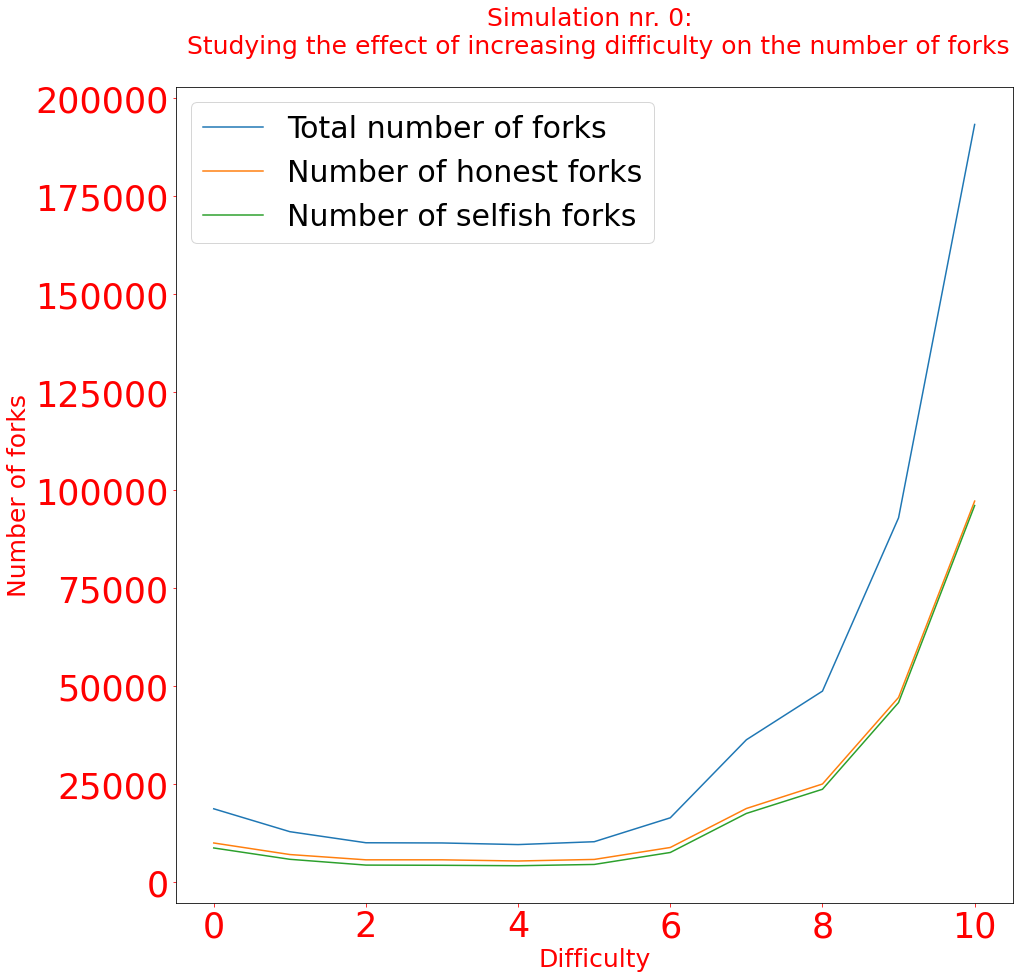

In [4]:
"""
Drawing the results of the previous simulation nr. 0
"""

import matplotlib.pyplot as plt

difficulty_range = list(sim_difficulty)

fig, axs = plt.subplots(1, 1, figsize=(15,15))

axs.plot(difficulty_range, number_of_forks_total, label = "Total number of forks")
axs.plot(difficulty_range, number_of_forks_honest, label = "Number of honest forks")
axs.plot(difficulty_range, number_of_forks_selfish, label = "Number of selfish forks")
axs.tick_params(axis='x', colors='red')
axs.tick_params(axis='y', colors='red')
axs.set_title('Simulation nr. 0: \n Studying the effect of increasing difficulty on the number of forks\n', fontsize=25).set_color('red')
axs.set_xlabel('Difficulty', fontsize=25).set_color('red')
axs.set_ylabel('Number of forks', fontsize=25).set_color('red')
axs.legend(prop={"size":30})
l = plt.setp(axs.get_xticklabels(), fontsize=35)
l = plt.setp(axs.get_yticklabels(), fontsize=35)


### Analysis and Comments on Simulation Results nr. 0
When we have increasing difficulty in an ecosystem where there are 50 honest and 50 selfish miners, and each miner have equal mining power and random network power, we observe the following:<br><br>
A) The lowest number of forks appears when the difficulty is between 2 and 4.<br><br>
B) After 4, the number of occuring forks grows logarithmic.<br><br>
C) Observation 1 and 2 above apply for all forks occuring under both honest and selfish mining, and therefore it also apply for the total sum of forks.<br><br>
D) From the plot above, all plot lines of the sum of forks does have an albue at difficulty 6 to 8 with a moderate number of forks occuring which is about 25 000 or less.<br><br>
E) Based on that we choose 7 as the initial target diffculty to our future simulations, but we will still keep track of the number of forks occuring, this is because forks are important to all of Selfish-, GHOST- and Stubborn- mining. as these strategies play out during the forking of blockchains. 

### Mining Power Simulation & Analysis
### Simulation nr. 1: 
In this simulation, we aim to study the effect of an increasing mining power of just one selfish miner, the simulation has the following setup:<br/><br/>
A) Total available mining power of 100.<br/><br/>
B) Starting the total selfish mining power at 0% of the total available mining power.<br/><br/>
C) Starting the total honest mining power at 50% of the total available mining power.<br/><br/>
D) Total number of miners is 100; 99 honest miners and 1 selfish miner at all times.<br/><br/>
E) Mining power will vary from one miner to another, beacuse we are:<br/><br/>
    1. Increasing the mining power of the 1 selfish miner from 0 to 50 with selfish_mining_power += 1 at each step.<br/>
    2. Decreasing the mining power of the 99 honest miners from 50 to 1 with honest_mining_power -= 1 at each step.<br/><br/>
F) Network power is equally random to all miners, so when forks appears between multiple longest blockchains, a random blockchain is picked up.<br/><br/>

Please note that we are only interested in observing a selfish mining power up to 51% as after that it is naturally more profitable to run a 51% attack instead of selfish mining attack.

In [5]:
"""
This method makes miners of a given type (selfish/honest), and
equally assign mining power to each miner within 
the given limits of mining power and number of miners.

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80, blockchain)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="selfish", num_of_miners=60, total_mining_power=20, blockchain)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    (i.e. mining power of 0). 
"""
def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    
    while len(miners) < num_of_miners:
        if remaining_mining_power == 0:
            mining_power = 0
        elif len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            remaining_mining_power -= mining_power
            
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 1, see table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
all_total_selfish_profits = []
all_total_honest_profits = []
all_number_of_forks_total = []
all_number_of_forks_honest = []
all_number_of_forks_selfish = []
sim_range_selfish = range(0, 61, 1)
sim_range_honest = range(61, 0, -1)

total_mining_power = 100
num_of_selfish_miners = 1
num_of_honest_miners = 99

repeat_each = 10
    
for selfish_mining_power in sim_range_selfish:
    honest_mining_power = total_mining_power-selfish_mining_power
    
    total_selfish_profits = []
    total_honest_profits = []
    number_of_forks_total = []
    number_of_forks_honest = []
    number_of_forks_selfish = []

    if output:
        print(f"-> {num_of_honest_miners} honest minors having {round(honest_mining_power)}% of total mining power")
        print(f"-> {num_of_selfish_miners} selfish minors having {round(selfish_mining_power)}% of total mining power")
            
    for repeat in range(repeat_each):
        if output:
            print(f"Running the simulation for the {repeat+1}th time out of {repeat_each} times")
            
        bc = Blockchain("0" , 7)
        honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc)
        selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power, bc)

        selfish_profits, honest_profits, num_forks_selfish, num_forks_honest = simulate_selfish_mining(bc, honest_miners, selfish_miners)
        
        sum_honest_profit = sum(honest_profits)
        total_honest_profits.append(sum_honest_profit*100) # multiplying by 100 for bettwer scale on the plot.

        sum_selfish_profit = sum(selfish_profits)
        total_selfish_profits.append(sum_selfish_profit*100) # multiplying by 100 for bettwer scale on the plot.
        
        number_of_forks_selfish.append(num_forks_selfish)
        number_of_forks_honest.append(num_forks_honest)
        number_of_forks_total.append(num_forks_honest+num_forks_selfish)
        
    selfish_profit = sum(total_selfish_profits) / len(total_selfish_profits)
    all_total_selfish_profits.append(selfish_profit)
    
    honest_profit = sum(total_honest_profits) / len(total_honest_profits)
    all_total_honest_profits.append(honest_profit)
    
    num_forks_honest = sum(number_of_forks_honest) / len(number_of_forks_honest)
    all_number_of_forks_honest.append(num_forks_honest)
    
    num_forks_selfish = sum(number_of_forks_selfish) / len(number_of_forks_selfish)
    all_number_of_forks_selfish.append(num_forks_selfish)
    
    num_forks_total = sum(number_of_forks_total) / len(number_of_forks_total)
    all_number_of_forks_total.append(num_forks_total)
    
    if output:
        print()
        print(f"Total Percentage Sum of Honest Profit: {honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {round(selfish_profit+honest_profit)}")
        print(f"Resulted Number of Honest Forks: {num_forks_honest}")
        print(f"Resulted Number of Selfish Forks: {num_forks_selfish}")
        print(f"Resulted Total Number of Forks: {num_forks_total}")
        print()


-> 99 honest minors having 100% of total mining power
-> 1 selfish minors having 0% of total mining power
Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 100.12593639645802
Total Percentage Sum of Selfish Profit: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 100
Resulted Number of Honest Forks: 18156.6
Resulted Number of Selfish Forks: 183.4
Resulted Total Number of Forks: 18340.0

-> 99 honest minors having 99% of total mining power
->

Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 95.11678695208734
Total Percentage Sum of Selfish Profit: 5.034728199427767
Total Percentage Sum of Profit (Honest+Selfish): 100
Resulted Number of Honest Forks: 19988.1
Resulted Number of Selfish Forks: 197.0
Resulted Total Number of Forks: 20185.1

-> 99 honest minors having 91% of total mining power
-> 1 selfish minors having 9% of total mining power
Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 82.84434511107042
Total Percentage Sum of Selfish Profit: 16.86128259455724
Total Percentage Sum of Profit (Honest+Selfish): 100
Resulted Number of Honest Forks: 18117.0
Resulted Number of Selfish Forks: 173.1
Resulted Total Number of Forks: 18290.1

-> 99 honest minors having 82% of total mining power
-> 1 selfish minors having 18% of total mining power
Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time ou

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 70.14010731983117
Total Percentage Sum of Selfish Profit: 30.17232737191386
Total Percentage Sum of Profit (Honest+Selfish): 100
Resulted Number of Honest Forks: 19334.7
Resulted Number of Selfish Forks: 185.9
Resulted Total Number of Forks: 19520.6

-> 99 honest minors having 73% of total mining power
-> 1 selfish minors having 27% of total mining power
Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time ou

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 59.353716741854136
Total Percentage Sum of Selfish Profit: 40.93001341687601
Total Percentage Sum of Profit (Honest+Selfish): 100
Resulted Number of Honest Forks: 20582.1
Resulted Number of Selfish Forks: 199.3
Resulted Total Number of Forks: 20781.4

-> 99 honest minors having 64% of total mining power
-> 1 selfish minors having 36% of total mining power
Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time o

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 49.255615612815134
Total Percentage Sum of Selfish Profit: 50.72519579069363
Total Percentage Sum of Profit (Honest+Selfish): 100
Resulted Number of Honest Forks: 20374.2
Resulted Number of Selfish Forks: 199.6
Resulted Total Number of Forks: 20573.8

-> 99 honest minors having 55% of total mining power
-> 1 selfish minors having 45% of total mining power
Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time o

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 68.54096324754343
Total Percentage Sum of Selfish Profit: 31.459036752456576
Total Percentage Sum of Profit (Honest+Selfish): 100
Resulted Number of Honest Forks: 21710.7
Resulted Number of Selfish Forks: 215.8
Resulted Total Number of Forks: 21926.5

-> 99 honest minors having 46% of total mining power
-> 1 selfish minors having 54% of total mining power
Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time o

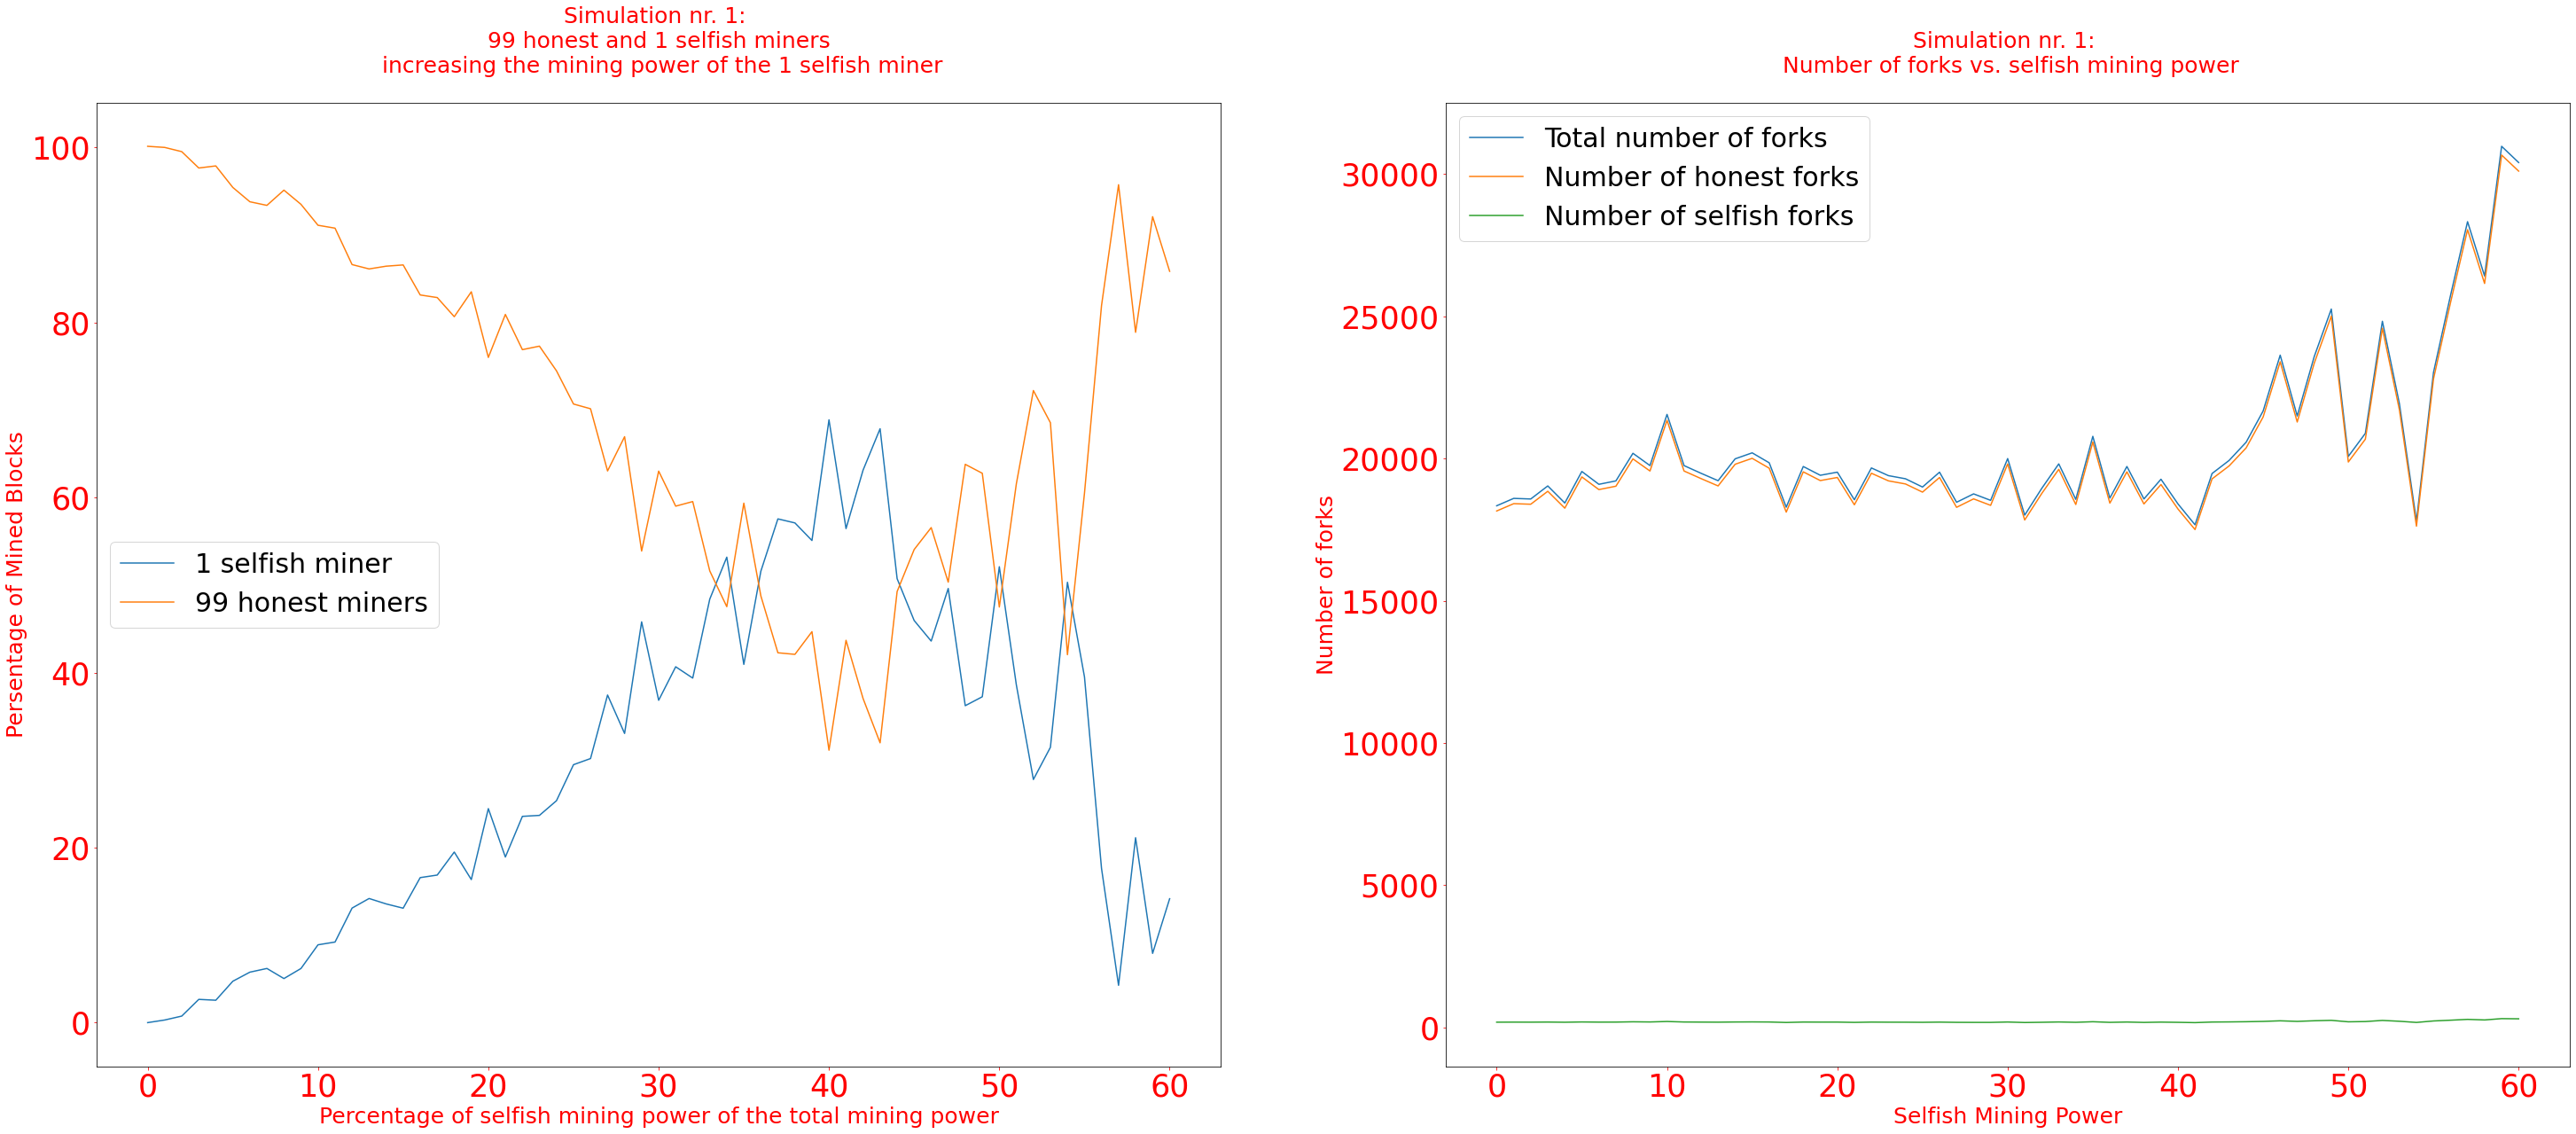

In [6]:
"""
Drawing the results of the previous simulation nr. 1
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)


fig, axs = plt.subplots(1, 2, figsize=(50,20))

# Plot 1: Percentage of selfish and honest profit with increasing selfish mining power
axs[0].plot(selfish_power, all_total_selfish_profits, label = "1 selfish miner")
axs[0].plot(selfish_power, all_total_honest_profits, label = "99 honest miners")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_title('Simulation nr. 1: \n 99 honest and 1 selfish miners \n increasing the mining power of the 1 selfish miner\n', fontsize=25).set_color('red')
axs[0].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=25).set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks', fontsize=25).set_color('red')
axs[0].legend(prop={"size":30})
l = plt.setp(axs[0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0].get_yticklabels(), fontsize=35)

# Plot 2: Number of occurring forks during selfish and honest mining, and their combined total.
axs[1].plot(selfish_power, all_number_of_forks_total, label = "Total number of forks")
axs[1].plot(selfish_power, all_number_of_forks_honest, label = "Number of honest forks")
axs[1].plot(selfish_power, all_number_of_forks_selfish, label = "Number of selfish forks")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_title('Simulation nr. 1: \n Number of forks vs. selfish mining power\n', fontsize=25).set_color('red')
axs[1].set_xlabel('Selfish Mining Power', fontsize=25).set_color('red')
axs[1].set_ylabel('Number of forks', fontsize=25).set_color('red')
axs[1].legend(prop={"size":30})
l = plt.setp(axs[1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1].get_yticklabels(), fontsize=35)


### Analysis and Comments on Simulation Results nr. 1
When we have 1 selfish miner and 99 honest miners, and we then increase the mining power of the selfish miner, while decreasing the mining power of the 99 honest miners, we observe the following:<br><br>

A) Selfish mining is more likely to be less profitable than honest mining as long as the one selfish miner has a mining power under 35% of the total mining power, but profit of selfish mining is increasing with the increased mining power of the selfish miner.<br><br>
B) However, when the selfish mining power is more than 35% of the total mining power, there exist a big competition between both types of miners.<br><br>
C) But does that mean selfish mining is a good strategy? The one Selfish miner was able to climb from 0% to 40% of total profit for a mining power less than 35%, perhaps it is a good strategy as long as the selfish miner is having a high mining power share of the total mining power compared to other miners.<br><br>
D) Looking at the right plot above where the number of forks is plotted; we clearly see that the number of forks faced by the selfish miner is stable and much lower than it is for the forks discovered by honest mining. This could be a side effect of having just 1 selfish miner against 99 other honest miners.<br><br>
E) Also as it is not expected the selfish mining becomes less profitable than honest mining after 51% selfish power share, this can also be due to the one only selfish miner against the other 99 honest miners, but if a miner have a 51% mining power of more, then it is much better and more profitable for him/her to run a 51% attack than selfish mining.

### Mining Power Analysis and Simulation
### Simulation nr. 2: 
In this simulation we aim to study the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal mining power, but where the number of selfish miners increases by 1, and at the same time the number of honest miners decreases by 1. This simulation has the following setup:<br><br>
A) Total number of miners is 100.<br><br>
B) Total available mining power of 100 units, 1 unit for each miner at all times.<br><br>
C) Starting the total selfish mining power at 0 (i.e. 0 selfish miners)<br><br>
D) Starting the total honest mining power at 100 (i.e. 100 honest miners)<br><br>
E) Each miner will have the same mining power as other miners, beacuse we are
* Increasing the selfish mining power from 0 to 99 with selfish_mining_power += 1, and 
    at the same time increasing the number of selfish miners from 0 to 99 with 
    num_selfish_miners += 1<br><br>
* Decreasing the honest mining power from 100 to 1 with honest_mining_power -= 1, and 
    at the same time decreasing the number of honest miners from 100 to 0 with 
    num_honest_miners -= 1<br><br>
    
F) Network power is equally random to all miners, so when forks appears between multiple longest blockchains, a random blockchain is picked up.

In [7]:
"""
This method makes miners of a given type of miners (selfish/honest), and
equally assign mining power to each miner within 
the given limits of mining power and number of miners

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", num_of_miners=40, total_mining_power=80)
> we should get an array of selfish miners, where each miner has 80/40 = 2 mining power

However if we call the same method with
> make_miners(type_of_minors="honest", num_of_miners=60, total_mining_power=20)
> due to the use of round method on calculating the individual mining power, 
    only 20 miners will get a power of 1 and the rest will have no mining power, 
    i.e. mining power of 0. 
"""
def make_miners(type_of_minors, num_of_miners, total_mining_power):
    miners = []
    remaining_mining_power = total_mining_power
    
    while remaining_mining_power > 0:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, f"Honest miner nr. {len(miners)+1}", bc)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, f"Selfish miner nr. {len(miners)+1}", bc)
        
        miners.append(miner)
        remaining_mining_power -= mining_power
        
    return miners

"""
The code below runs simulation nr. 2, se table at the head of this notebook for summary details
"""
output = True # Set this to False to disable update messages from simulations
all_total_selfish_profits = []
all_total_honest_profits = []

all_average_selfish_profits = []
all_average_honest_profits = []

all_number_of_forks_total = []
all_number_of_forks_honest = []
all_number_of_forks_selfish = []

sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

repeat_each = 10

for selfish_power in sim_range_selfish:
    total_mining_power = 100
    
    num_of_honest_miners = total_mining_power-selfish_power
    honest_power_share = round(num_of_honest_miners/100, 2)
    honest_mining_power = round(total_mining_power * honest_power_share)
    
    num_of_selfish_miners = selfish_power
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    
    total_selfish_profits = []
    total_honest_profits = []
    
    avg_selfish_profits = []
    avg_honest_profits = []
    
    number_of_forks_total = []
    number_of_forks_honest = []
    number_of_forks_selfish = []
    
    if output:
        print(f"Running simulation of mining power with:")
        print(f"-> {num_of_honest_miners} honest miners having {round(honest_mining_power)}% of total mining power")
        print(f"-> {num_of_selfish_miners} selfish miners having {round(selfish_mining_power)}% of total mining power")
        print()
        
    for repeat in range(repeat_each):
        if output:
            print(f"Running the simulation for the {repeat+1}th time out of {repeat_each} times")
            
        bc = Blockchain("0" , 7)
    
        honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power)
        selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power)
        
        selfish_profits, honest_profits, num_forks_selfish, num_forks_honest = simulate_selfish_mining(bc, honest_miners, selfish_miners)
        
        sum_selfish_profit = sum(selfish_profits)
        total_selfish_profits.append(sum_selfish_profit*100)
        
        sum_honest_profit = sum(honest_profits)
        total_honest_profits.append(sum_honest_profit*100)
    
        if len(selfish_profits) != 0:
            average_selfish_profit = sum(selfish_profits) / len(selfish_profits)
        else:
            average_selfish_profit = 0
        avg_selfish_profits.append(average_selfish_profit*100) # multiplied by 100 for better scale 
        
        if len(honest_profits) != 0:
            average_honest_profit = sum(honest_profits) / len(honest_profits)
        else:
            average_honest_profit = 0
        avg_honest_profits.append(average_honest_profit*100)
        
        number_of_forks_total.append(num_forks_selfish+num_forks_honest)
        number_of_forks_honest.append(num_forks_honest)
        number_of_forks_selfish.append(num_forks_selfish)
        
    sum_honest_profit = sum(total_honest_profits) / len(total_honest_profits)
    all_total_honest_profits.append(sum_honest_profit)
    
    sum_selfish_profit = sum(total_selfish_profits) / len(total_selfish_profits)
    all_total_selfish_profits.append(sum_selfish_profit)
    
    average_honest_profit = sum(avg_honest_profits) / len(avg_honest_profits)
    all_average_honest_profits.append(average_honest_profit)
    
    average_selfish_profit = sum(avg_selfish_profits) / len(avg_selfish_profits)
    all_average_selfish_profits.append(average_selfish_profit) 
    
    num_honest_forks = sum(number_of_forks_honest) / len(number_of_forks_honest)
    all_number_of_forks_honest.append(num_honest_forks)
    
    num_selfish_forks = sum(number_of_forks_selfish) / len(number_of_forks_selfish)
    all_number_of_forks_selfish.append(num_forks_selfish) 
    
    num_total_forks = sum(number_of_forks_total) / len(number_of_forks_total)
    all_number_of_forks_total.append(num_total_forks)
    
    if output:
        print()
        print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {sum_selfish_profit}, Average: {average_selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {sum_selfish_profit+sum_honest_profit}")
        print(f"Resulted Number of Honest Forks: {num_honest_forks}")
        print(f"Resulted Number of Selfish Forks: {num_selfish_forks}")
        print(f"Resulted Total Number of Forks: {num_total_forks}")
        print()

Running simulation of mining power with:
-> 100 honest miners having 100% of total mining power
-> 0 selfish miners having 0% of total mining power

Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 99.69822123914187, Average: 0.9969822123914189
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 99.69822123914187
Resulted Number of Honest Forks: 17990.0
Resulted Number of Selfish Forks: 0.0

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 94.97768027556884, Average: 1.0323660899518352
Total Percentage Sum of Selfish Profit: 4.543631505251832, Average: 0.567953938156479
Total Percentage Sum of Profit (Honest+Selfish): 99.52131178082068
Resulted Number of Honest Forks: 17875.6
Resulted Number of Selfish Forks: 1513.2
Resulted Total Number of Forks: 19388.8

Running simulation of mining power with:
-> 91 honest miners having 91% of total mining power
-> 9 selfish miners having 9% of total

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 91.16307241563766, Average: 1.0852746716147343
Total Percentage Sum of Selfish Profit: 9.507485395989853, Average: 0.5942178372493658
Total Percentage Sum of Profit (Honest+Selfish): 100.6705578116275
Resulted Number of Honest Forks: 18387.6
Resulted Number of Selfish Forks: 3369.5
Resulted Total Number of Forks: 21757.1

Running simulation of mining power with:
-> 83 honest miners having 83% of total mining power
-> 17 selfish miners having 17% of to

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 86.53811126868369, Average: 1.1386593587984695
Total Percentage Sum of Selfish Profit: 13.312423482204824, Average: 0.5546843117585343
Total Percentage Sum of Profit (Honest+Selfish): 99.85053475088851
Resulted Number of Honest Forks: 17366.0
Resulted Number of Selfish Forks: 5207.7
Resulted Total Number of Forks: 22573.7

Running simulation of mining power with:
-> 75 honest miners having 75% of total mining power
-> 25 selfish miners having 25% of t

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 79.46779307681837, Average: 1.1686440158355642
Total Percentage Sum of Selfish Profit: 20.768689394958223, Average: 0.6490215435924445
Total Percentage Sum of Profit (Honest+Selfish): 100.23648247177658
Resulted Number of Honest Forks: 17659.6
Resulted Number of Selfish Forks: 7821.4
Resulted Total Number of Forks: 25481.0

Running simulation of mining power with:
-> 67 honest miners having 67% of total mining power
-> 33 selfish miners having 33% of 

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 72.28464520868478, Average: 1.204744086811413
Total Percentage Sum of Selfish Profit: 27.206674254654068, Average: 0.6801668563663515
Total Percentage Sum of Profit (Honest+Selfish): 99.49131946333884
Resulted Number of Honest Forks: 16344.0
Resulted Number of Selfish Forks: 10071.8
Resulted Total Number of Forks: 26415.8

Running simulation of mining power with:
-> 59 honest miners having 59% of total mining power
-> 41 selfish miners having 41% of t

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 66.97217983544402, Average: 1.2879265352970006
Total Percentage Sum of Selfish Profit: 32.79526202502108, Average: 0.6832346255212725
Total Percentage Sum of Profit (Honest+Selfish): 99.76744186046511
Resulted Number of Honest Forks: 15896.4
Resulted Number of Selfish Forks: 13436.8
Resulted Total Number of Forks: 29333.2

Running simulation of mining power with:
-> 51 honest miners having 51% of total mining power
-> 49 selfish miners having 49% of t

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 63.27981520574838, Average: 1.438177618312463
Total Percentage Sum of Selfish Profit: 36.778838488287384, Average: 0.6567649730051318
Total Percentage Sum of Profit (Honest+Selfish): 100.05865369403577
Resulted Number of Honest Forks: 14528.8
Resulted Number of Selfish Forks: 16963.0
Resulted Total Number of Forks: 31491.8

Running simulation of mining power with:
-> 43 honest miners having 43% of total mining power
-> 57 selfish miners having 57% of 

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 51.51065706117373, Average: 1.4308515850326036
Total Percentage Sum of Selfish Profit: 49.57042401990735, Average: 0.7745378753110523
Total Percentage Sum of Profit (Honest+Selfish): 101.08108108108108
Resulted Number of Honest Forks: 13096.8
Resulted Number of Selfish Forks: 21512.5
Resulted Total Number of Forks: 34609.3

Running simulation of mining power with:
-> 35 honest miners having 35% of total mining power
-> 65 selfish miners having 65% of 

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 52.68167532995119, Average: 1.881488404641114
Total Percentage Sum of Selfish Profit: 48.7547388306009, Average: 0.6771491504250124
Total Percentage Sum of Profit (Honest+Selfish): 101.43641416055209
Resulted Number of Honest Forks: 10824.8
Resulted Number of Selfish Forks: 25759.3
Resulted Total Number of Forks: 36584.1

Running simulation of mining power with:
-> 27 honest miners having 27% of total mining power
-> 73 selfish miners having 73% of to

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 39.531714584309256, Average: 1.9765857292154625
Total Percentage Sum of Selfish Profit: 59.99813494904657, Average: 0.7499766868630824
Total Percentage Sum of Profit (Honest+Selfish): 99.52984953335583
Resulted Number of Honest Forks: 10126.0
Resulted Number of Selfish Forks: 38213.7
Resulted Total Number of Forks: 48339.7

Running simulation of mining power with:
-> 19 honest miners having 19% of total mining power
-> 81 selfish miners having 81% of 

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 26.332415084952437, Average: 2.1943679237460367
Total Percentage Sum of Selfish Profit: 71.14344881722725, Average: 0.808448282013946
Total Percentage Sum of Profit (Honest+Selfish): 97.4758639021797
Resulted Number of Honest Forks: 6979.2
Resulted Number of Selfish Forks: 48925.2
Resulted Total Number of Forks: 55904.4

Running simulation of mining power with:
-> 11 honest miners having 11% of total mining power
-> 89 selfish miners having 89% of tot

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 7.9966914301952645, Average: 1.9991728575488161
Total Percentage Sum of Selfish Profit: 94.84868875086268, Average: 0.9880071744881528
Total Percentage Sum of Profit (Honest+Selfish): 102.84538018105795
Resulted Number of Honest Forks: 2657.6
Resulted Number of Selfish Forks: 62342.1
Resulted Total Number of Forks: 64999.7

Running simulation of mining power with:
-> 3 honest miners having 3% of total mining power
-> 97 selfish miners having 97% of to

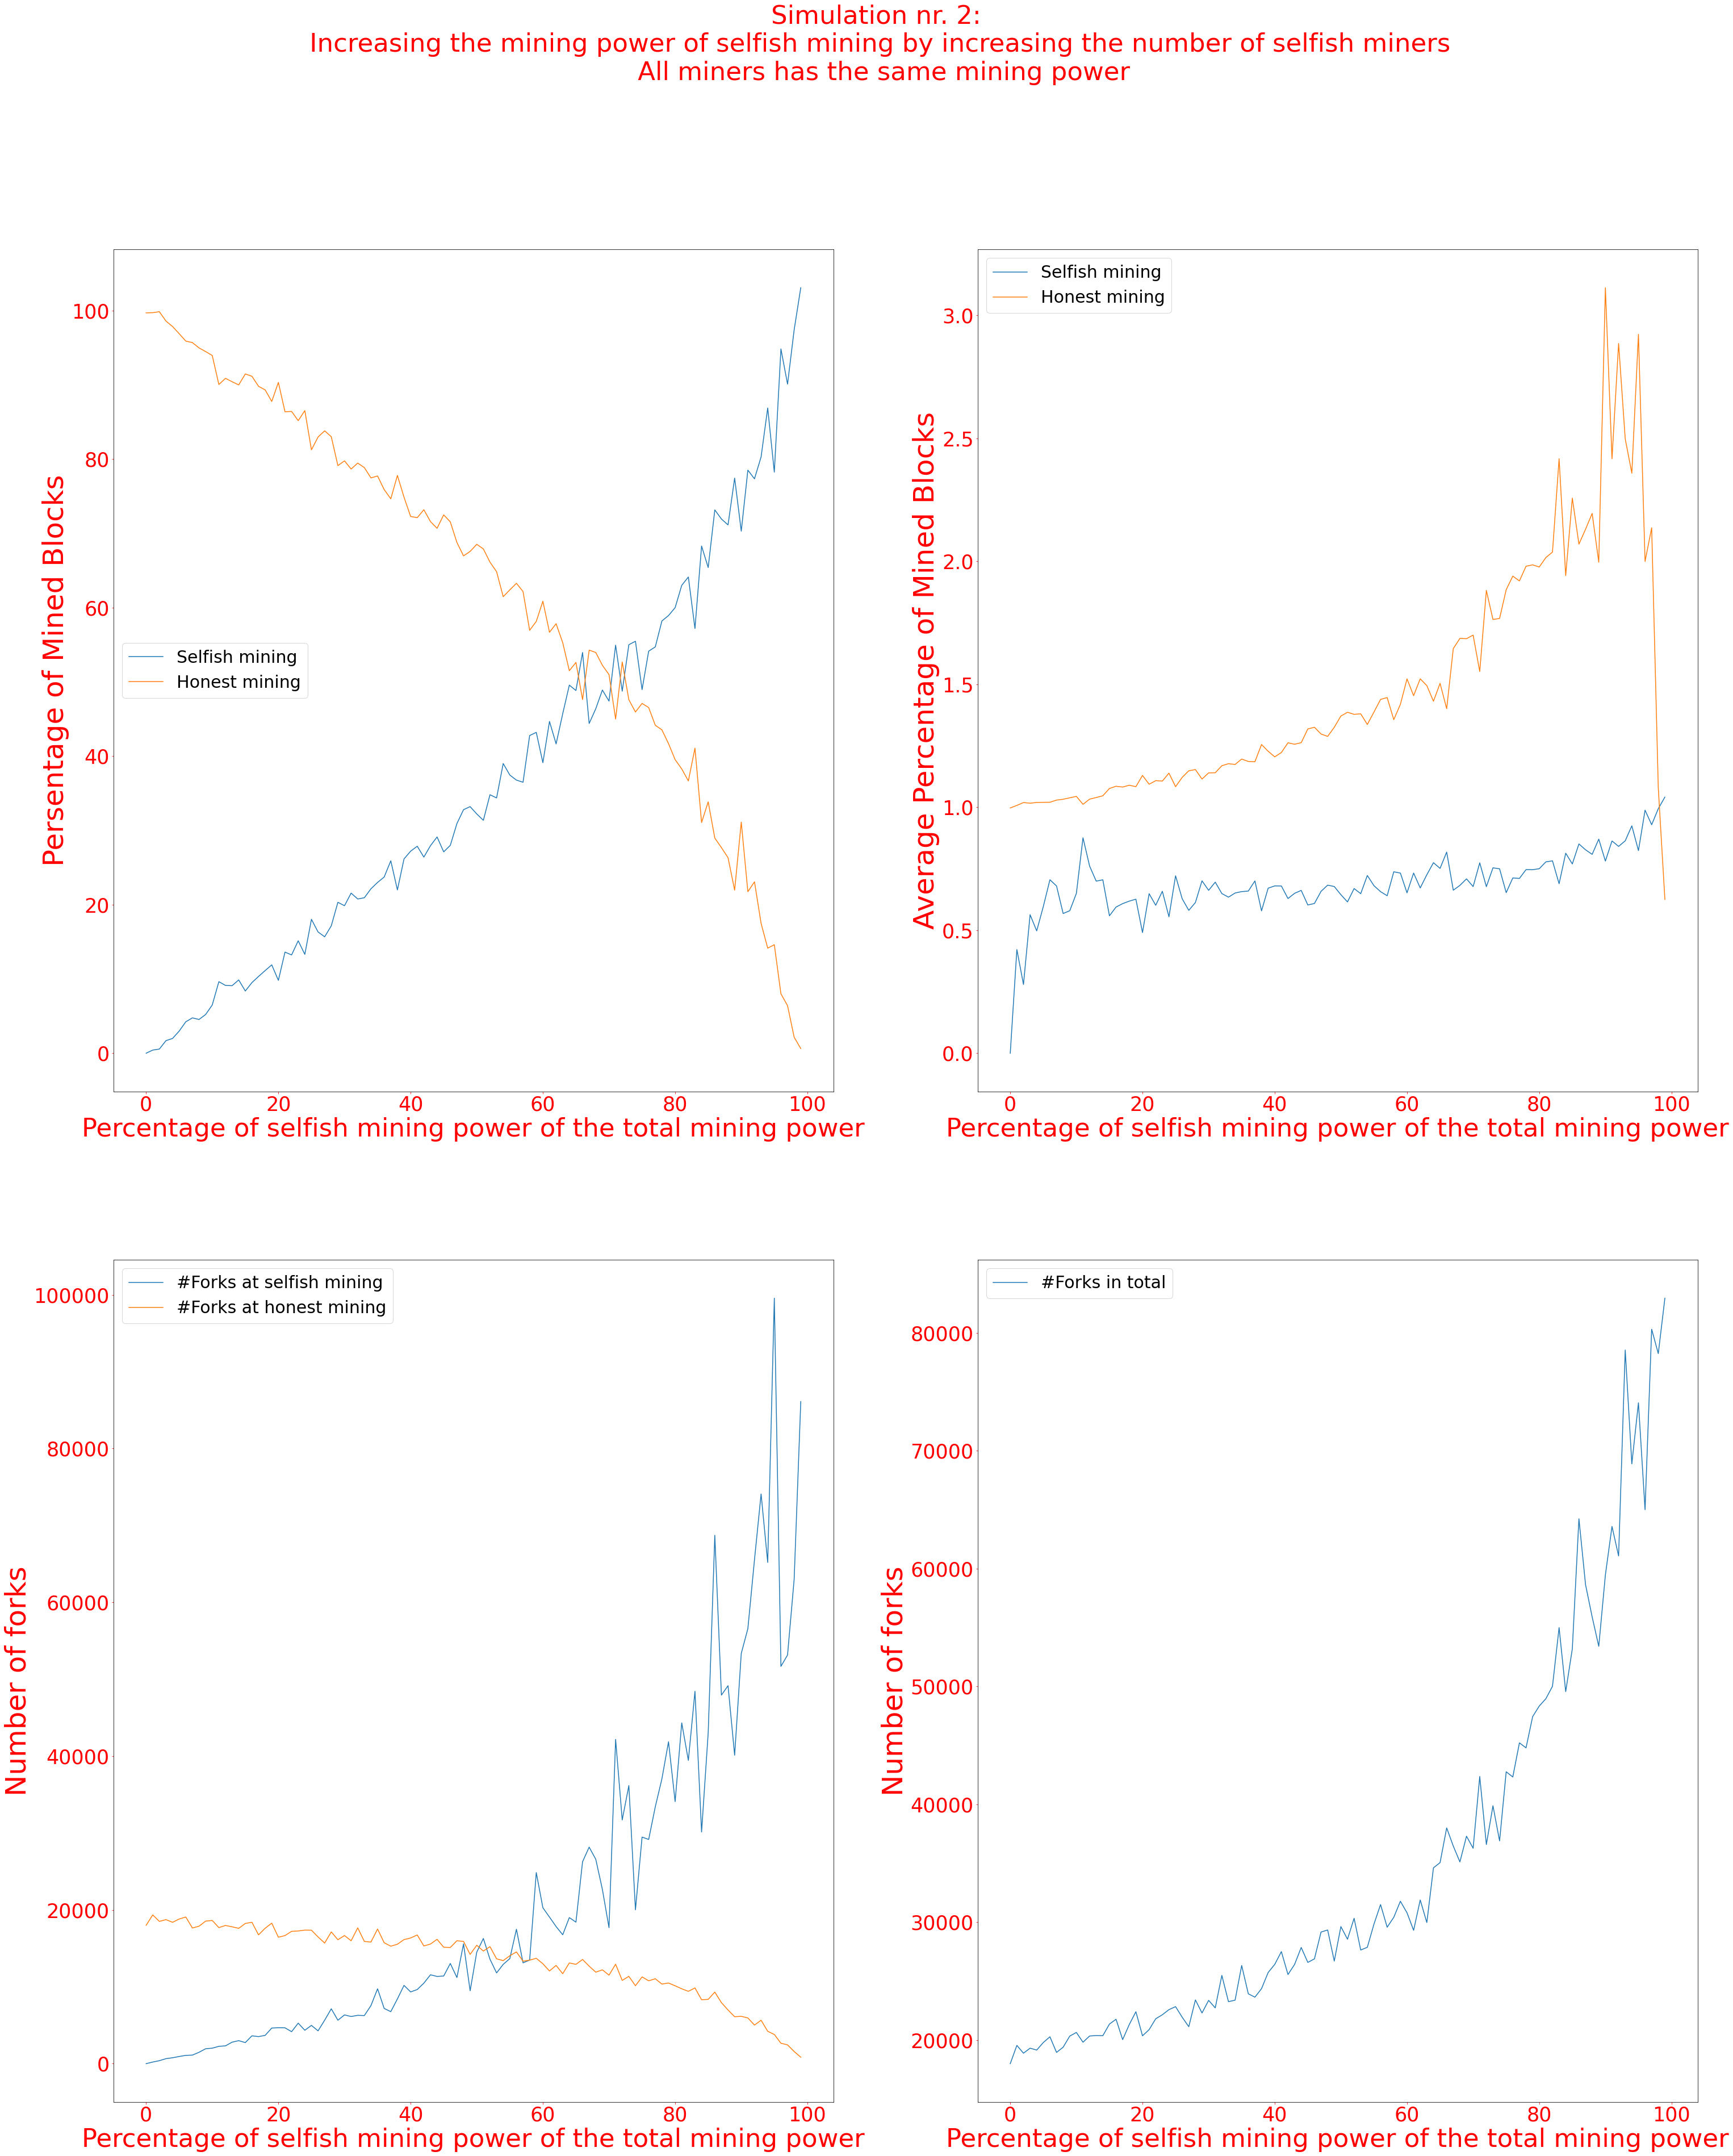

In [8]:
"""
Drawing the results of the previous simulation nr. 2
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(2, 2, figsize=(50,60))
fig.suptitle('Simulation nr. 2: \n Increasing the mining power of selfish mining by increasing the number of selfish miners \n All miners has the same mining power\n', fontsize=45).set_color('red')  

# Plot 1: Percentage of selfish and honest profit with increasing selfish mining power
axs[0, 0].plot(selfish_power, all_total_selfish_profits, label = "Selfish mining")
axs[0, 0].plot(selfish_power, all_total_honest_profits, label = "Honest mining")
axs[0, 0].tick_params(axis='x', colors='red')
axs[0, 0].tick_params(axis='y', colors='red')
axs[0, 0].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[0, 0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 0].legend(prop={"size":30})
l = plt.setp(axs[0, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 0].get_yticklabels(), fontsize=35)

# Plot 2: Average of profit between miners
axs[0, 1].plot(selfish_power, all_average_selfish_profits, label = "Selfish mining")
axs[0, 1].plot(selfish_power, all_average_honest_profits, label = "Honest mining")
axs[0, 1].tick_params(axis='x', colors='red')
axs[0, 1].tick_params(axis='y', colors='red')
axs[0, 1].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[0, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 1].legend(prop={"size":30})
l = plt.setp(axs[0, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 1].get_yticklabels(), fontsize=35)

# Plot 3: Number of occurring forks during both selfish and honest mining
axs[1, 0].plot(selfish_power, all_number_of_forks_selfish, label = "#Forks at selfish mining")
axs[1, 0].plot(selfish_power, all_number_of_forks_honest, label = "#Forks at honest mining")
axs[1, 0].tick_params(axis='x', colors='red')
axs[1, 0].tick_params(axis='y', colors='red')
axs[1, 0].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[1, 0].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 0].legend(prop={"size":30})
l = plt.setp(axs[1, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 0].get_yticklabels(), fontsize=35)

# plot 4: Total number of occurring forks.
axs[1, 1].plot(selfish_power, all_number_of_forks_total, label = "#Forks in total")
axs[1, 1].tick_params(axis='x', colors='red')
axs[1, 1].tick_params(axis='y', colors='red')
axs[1, 1].set_xlabel('Percentage of selfish mining power of the total mining power', fontsize=45).set_color('red')
axs[1, 1].set_ylabel('Number of forks', fontsize=50).set_color('red')
axs[1, 1].legend(prop={"size":30})
l = plt.setp(axs[1, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 1].get_yticklabels(), fontsize=35)

## Analysis and Comments on Simulation Results nr. 2
When we increase the selfish mining power by inreasing the number of selfish miners and decreasing the number of honest miners, we observe the following:<br><br>

A) Selfish mining is less profitable than honest mining under 60% selfish mining power.<br><br>

B) However, the profit inreases with increased number of selfish miners, and the same happens for honest miners as well but in the opposite direction because of the decrease in the number of honest miners.<br><br>

C) The average plot in the upper right corner above shows that on average, an honest miner gets a bigger share in the total profit of honest mining, than the share of a selfish miner in the total profit of selfish mining.<br><br>

D) The upper 2 plots show that selfish mining is depending on the honest miners to make more profit, this is because we observe lower share for the average selfish miner in the selfish profit than the share of the average honest miner in the honest profit, even after these power intervals (after 70 selfish miners) where the selfish profit is higher than the honest profit in total.<br><br>

E) In the lower 2 plots, we observe that the number of forks occuring during honest mining decreases along the decrease of honest miners, and the same relation applies for the increase of selfish miners. However, selfish miners tends to face much more forks when increasing the number of selfish miners due to the operation of selfish mining.


### Network Power Simulation & Analysis
### The following redesign steps was added to the previous core classes to implement a way to simulate network power<br>

A) Network Power will be used in the longestChain() method to increase the chances of a certain block creator to have his block and its previous blockchain replicated faster than other blocks from other miners with low network power, this simulation method is also known as weighted random. <br><br>

B) Please note that the block is still chossen randomly in the longestChain() method. However, now we are increasing the chances by checking the network power of the miner who created that block and if it is found out to be smaller than a randomly generated number between 0 to 100 than his block gets replicated and if not, his block does not get replicated across the network in the simulation. <br><br>

C) Redesigning the longestChain() method in the Blockchain class to simulate network power.<br><br>

D) Adding an additional attribute to define the network power of a certain miner in the Miner and SelfishMiner classes.<br><br>

E) Editing the Block class to implement the changes in above.<br><br>

The cell below implement these specified changes.

In [23]:
class Block:
    def __init__(self, data, creator=None, previous=None, nonce=0):
        self.data = data
        if previous is None:
            self.previous = None
            self.previous_hash = ""
            if creator != None:
                self.creator = Miner(0 , creator.networkingPower, creator.miner_type ,"0")
            else:
                self.creator = Miner(0 , None, None, "0")
            self.height = 0
        else:
            self.previous = previous
            self.previous_hash = previous.hash
            self.creator = creator
            self.height = previous.height+1
        self.nonce = nonce
        self.hash = self.hash_block()
        self.children = []

    def hash_block(self):
        return hashbits(self.data+ self.creator.name + self.previous_hash + str(self.nonce))


class Blockchain:
    def __init__(self, genesis_data, difficulty):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0

    def longestChain(self):
        max = self.chain[0].height
        for block in self.chain:
            if block.height > max:
                max = block.height
        maxes = [block for block in self.chain if block.height == max]
        
        new_maxes = []
        if len(maxes) > 1:
            chances = list(range(1, 101, 1))
            choice = random.choice(chances)
            for block in maxes:
                creator_networking_power = block.creator.networkingPower
                if choice <= creator_networking_power:
                    new_maxes.append(block)
        else:
            new_maxes = maxes
            
        if len(new_maxes) == 0:
            new_maxes = maxes
        return new_maxes[0], len(maxes)
        
    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1

    def checkMiner(self, miner):
        last, _ = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count
            
class Miner:
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        self.miningPower = miningPower
        self.networkingPower = networkingPower
        self.miner_type = miner_type
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock, _ = blockchain.longestChain()
  
    def UpdateLast(self):
        latest, num_forks = self.blockchain.longestChain()
        if latest.height > self.lastBlock.height:
            self.lastBlock = latest
        return num_forks
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

class SelfishMiner(Miner):
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None):
        super().__init__(miningPower, networkingPower, miner_type, name, blockchain)
        self.privateBlocks = []
        self.publishNext = False

    def UpdateLast(self):
        latest, num_forks = self.blockchain.longestChain()
        publicheight = latest.height
        if publicheight > self.lastBlock.height:
            self.privateBlocks = []
            self.lastBlock = latest
            self.publishNext = False
        if publicheight == self.lastBlock.height-1 and len(self.privateBlocks)> 1:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
        if publicheight == self.lastBlock.height:
            for block in self.privateBlocks:
                self.blockchain.add(block)
                self.privateBlocks = []
                self.publishNext = True
        return num_forks

    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                if self.publishNext:
                    self.blockchain.add(newBlock)
                    self.publishNext = False
                else:
                    self.privateBlocks.append(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

### Network Power Analysis and Simulation
### Simulation nr. 3: 
In this simulation, we aim to study the effect of an increasing network power of just one selfish miner against 99 honest miners, the simulation has the following setup:

A) Total available network power of 100.<br><br>

B) Starting the total selfish network power at 0.<br><br>

C) Starting the total honest network power at 100.<br><br>

C) Total number of miners is 100, always having 99 honest miners and 1 selfish miner.<br><br>

D) Network power will vary from one miner to another, beacuse we are <br>
    1. Increasing the network power of the 1 selfish miner from 0 to 99 with selfish_network_power += 1, and <br>
    2. Decreasing the network power of the 99 honest miners from 100 to 1 with honest_network_power -= 1.<br><br>

E) Total mining power is 100 and it is divided equally among all miners, so each miner of the 100 miners will have a mining power of 1 no matter if he is a selfish or honest miner. This is done to isolate the effect of network power from the effect of mining power in the mining results.

In [ ]:
"""
This method makes miners of a given type (selfish/honest), and
divides the mining power share equally on the generated miners

example:
> if we make the following call:
> make_miners(type_of_minors="selfish", total_network_power=40, num_of_miners=40, total_mining_power=80)
> we should get an array of 40 selfish miners, where each miner has
> 80/40 = 2 mining power, and 40/40 = 1 network power

However if we call the same method with
> make_miners(type_of_minors="honest", total_network_power=40, num_of_miners=60, total_mining_power=40)
> we should get an array of 40 honest miners, where each miner has
> 40/40 = 1 mining power, and
> 40 of these honest miners has a network power of 1 and
> 20 has a network power of 0 (i.e. they are inactive or offline on the network)
"""
def make_miners(type_of_minors, total_network_power, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    remaining_network_power = total_network_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
            network_power = remaining_network_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            if remaining_mining_power < 0:
                mining_power = 0
            else:
                mining_power = 1
            remaining_mining_power -= mining_power
                
            network_power = round(total_network_power/num_of_miners)
            if remaining_network_power <= 0:
                network_power = 0
            else:
                network_power = 1
            remaining_network_power -= network_power
        
        if type_of_minors == "honest":
            miner = Miner(mining_power, network_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, network_power, "Selfish", f"Selfish miner nr. {len(miners)+1}", blockchain)

        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 3, se table at the head of this notebook for summary details
"""
output = True

all_total_selfish_profits = []
all_total_honest_profits = []

all_average_selfish_profits = []
all_average_honest_profits = []

all_number_of_forks_total = []
all_number_of_forks_honest = []
all_number_of_forks_selfish = []

sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

repeat_each = 10

for selfish_network_power in sim_range_selfish:
    num_of_selfish_miners = 1
    num_of_honest_miners = 99
    total_mining_power = 100
    honest_power_share = round(num_of_honest_miners/100, 2)
    selfish_power_share = round(num_of_selfish_miners/100, 2)
    honest_mining_power = round(total_mining_power * honest_power_share)
    selfish_mining_power = round(total_mining_power * selfish_power_share)
    selfish_networking_power = selfish_network_power
    honest_networking_power = 100-selfish_network_power
    
    total_selfish_profits = []
    total_honest_profits = []
    
    avg_selfish_profits = []
    avg_honest_profits = []
    
    number_of_forks_total = []
    number_of_forks_honest = []
    number_of_forks_selfish = []
    
    if output:
        print(f"Running simulation of networking power with:")
        print(f"-> {num_of_honest_miners} honest miners having {honest_networking_power}% of total networking power")
        print(f"-> {num_of_selfish_miners} selfish miners having {selfish_networking_power}% of total networking power")
        print()
    
    for repeat in range(repeat_each):
        if output:
            print(f"Running the simulation for the {repeat+1}th time out of {repeat_each} times")
        
        bc = Blockchain("0" , 7)
    
        honest_miners = make_miners("honest", honest_networking_power, num_of_honest_miners, honest_mining_power, bc)
    
        selfish_miners = make_miners("selfish", selfish_networking_power, num_of_selfish_miners, selfish_mining_power, bc)
    
        selfish_profits, honest_profits, num_forks_selfish, num_forks_honest = simulate_selfish_mining(bc, honest_miners, selfish_miners)
        
        sum_selfish_profit = sum(selfish_profits)
        total_selfish_profits.append(sum_selfish_profit*100)
        
        sum_honest_profit = sum(honest_profits)
        total_honest_profits.append(sum_honest_profit*100)
    
        if len(selfish_profits) != 0:
            average_selfish_profit = sum(selfish_profits) / len(selfish_profits)
        else:
            average_selfish_profit = 0
        avg_selfish_profits.append(average_selfish_profit*100) # multiplied by 100 for better scale 
        
        if len(honest_profits) != 0:
            average_honest_profit = sum(honest_profits) / len(honest_profits)
        else:
            average_honest_profit = 0
        avg_honest_profits.append(average_honest_profit*100)
        
        number_of_forks_total.append(num_forks_selfish+num_forks_honest)
        number_of_forks_honest.append(num_forks_honest)
        number_of_forks_selfish.append(num_forks_selfish)

    sum_honest_profit = sum(total_honest_profits) / len(total_honest_profits)
    all_total_honest_profits.append(sum_honest_profit)
    
    sum_selfish_profit = sum(total_selfish_profits) / len(total_selfish_profits)
    all_total_selfish_profits.append(sum_selfish_profit)
    
    average_honest_profit = sum(avg_honest_profits) / len(avg_honest_profits)
    all_average_honest_profits.append(average_honest_profit)
    
    average_selfish_profit = sum(avg_selfish_profits) / len(avg_selfish_profits)
    all_average_selfish_profits.append(average_selfish_profit) 
    
    num_honest_forks = sum(number_of_forks_honest) / len(number_of_forks_honest)
    all_number_of_forks_honest.append(num_honest_forks)
    
    num_selfish_forks = sum(number_of_forks_selfish) / len(number_of_forks_selfish)
    all_number_of_forks_selfish.append(num_forks_selfish) 
    
    num_total_forks = sum(number_of_forks_total) / len(number_of_forks_total)
    all_number_of_forks_total.append(num_total_forks)
    
    if output:
        print()
        print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {sum_selfish_profit}, Average: {average_selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {sum_selfish_profit+sum_honest_profit}")
        print(f"Resulted Number of Honest Forks: {num_honest_forks}")
        print(f"Resulted Number of Selfish Forks: {num_selfish_forks}")
        print(f"Resulted Total Number of Forks: {num_total_forks}")
        print()
    


Running simulation of networking power with:
-> 99 honest miners having 100% of total networking power
-> 1 selfish miners having 0% of total networking power

Running the simulation for the 1th time out of 10 times
Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 99.69230769230765, Average: 1.0069930069930064
Total Percentage Sum of Selfish Profit: 0.3076923076923077, Average: 0.3076923076923077
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999996
Resulted Number of Honest Forks: 1825

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 99.99999999999994, Average: 1.0101010101010093
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999994
Resulted Number of Honest Forks: 18414.0
Resulted Number of Selfish Forks: 185.0
Resulted Total Number of Forks: 18599.0

Running simulation of networking power with:
-> 99 honest miners having 91% of total networking power
-> 1 selfish miners having 9% of total networking power

Ru

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 99.99999999999997, Average: 1.01010101010101
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999997
Resulted Number of Honest Forks: 18374.4
Resulted Number of Selfish Forks: 184.8
Resulted Total Number of Forks: 18559.2

Running simulation of networking power with:
-> 99 honest miners having 83% of total networking power
-> 1 selfish miners having 17% of total networking power

Run

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 99.71780604133541, Average: 1.0072505660740947
Total Percentage Sum of Selfish Profit: 0.2821939586645469, Average: 0.2821939586645469
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999996
Resulted Number of Honest Forks: 18404.1
Resulted Number of Selfish Forks: 184.7
Resulted Total Number of Forks: 18588.8

Running simulation of networking power with:
-> 99 honest miners having 75% of total networking power
-> 1 selfish miners having 25

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 99.40791882582924, Average: 1.0041203921800934
Total Percentage Sum of Selfish Profit: 0.5920811741707264, Average: 0.5920811741707264
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999997
Resulted Number of Honest Forks: 18344.7
Resulted Number of Selfish Forks: 184.5
Resulted Total Number of Forks: 18529.2

Running simulation of networking power with:
-> 99 honest miners having 67% of total networking power
-> 1 selfish miners having 33

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 98.6890173093119, Average: 0.9968587607001202
Total Percentage Sum of Selfish Profit: 1.3109826906880326, Average: 1.3109826906880326
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999993
Resulted Number of Honest Forks: 18948.6
Resulted Number of Selfish Forks: 190.3
Resulted Total Number of Forks: 19138.9

Running simulation of networking power with:
-> 99 honest miners having 59% of total networking power
-> 1 selfish miners having 41%

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 99.32303541544874, Average: 1.0032629839944316
Total Percentage Sum of Selfish Profit: 0.6769645845512281, Average: 0.6769645845512281
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999997
Resulted Number of Honest Forks: 19017.9
Resulted Number of Selfish Forks: 190.9
Resulted Total Number of Forks: 19208.8

Running simulation of networking power with:
-> 99 honest miners having 51% of total networking power
-> 1 selfish miners having 49

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 99.44243466889614, Average: 1.004469037059557
Total Percentage Sum of Selfish Profit: 0.5575653311038223, Average: 0.5575653311038223
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999996
Resulted Number of Honest Forks: 18780.3
Resulted Number of Selfish Forks: 188.9
Resulted Total Number of Forks: 18969.2

Running simulation of networking power with:
-> 99 honest miners having 43% of total networking power
-> 1 selfish miners having 57%

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 98.95935230059077, Average: 0.9995894171776847
Total Percentage Sum of Selfish Profit: 1.0406476994091867, Average: 1.0406476994091867
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999996
Resulted Number of Honest Forks: 18503.1
Resulted Number of Selfish Forks: 185.7
Resulted Total Number of Forks: 18688.8

Running simulation of networking power with:
-> 99 honest miners having 35% of total networking power
-> 1 selfish miners having 65

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times
Running the simulation for the 10th time out of 10 times

Total Percentage Sum of Honest Profit: 98.42927979104971, Average: 0.9942351494045425
Total Percentage Sum of Selfish Profit: 1.5707202089502477, Average: 1.5707202089502477
Total Percentage Sum of Profit (Honest+Selfish): 99.99999999999996
Resulted Number of Honest Forks: 19037.7
Resulted Number of Selfish Forks: 191.2
Resulted Total Number of Forks: 19228.9

Running simulation of networking power with:
-> 99 honest miners having 27% of total networking power
-> 1 selfish miners having 73

Running the simulation for the 2th time out of 10 times
Running the simulation for the 3th time out of 10 times
Running the simulation for the 4th time out of 10 times
Running the simulation for the 5th time out of 10 times
Running the simulation for the 6th time out of 10 times
Running the simulation for the 7th time out of 10 times
Running the simulation for the 8th time out of 10 times
Running the simulation for the 9th time out of 10 times


In [ ]:
"""
Drawing the results of the previous simulation nr. 3
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)


fig, axs = plt.subplots(1, 2, figsize=(50,20))

# Plot 1: Percentage of selfish and honest profit with increasing selfish network power
axs[0].plot(selfish_power, all_total_selfish_profits, label = "1 selfish miner")
axs[0].plot(selfish_power, all_total_honest_profits, label = "99 honest miners")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_title('Simulation nr. 3: \n 99 honest and 1 selfish miners \n increasing the network power of the 1 selfish miner\n', fontsize=25).set_color('red')
axs[0].set_xlabel('Percentage of selfish network power of the total mining power', fontsize=25).set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks', fontsize=25).set_color('red')
axs[0].legend(prop={"size":30})
l = plt.setp(axs[0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0].get_yticklabels(), fontsize=35)

# Plot 2: Number of occurring forks during selfish and honest mining, and their combined total.
axs[1].plot(selfish_power, all_number_of_forks_total, label = "Total number of forks")
axs[1].plot(selfish_power, all_number_of_forks_honest, label = "Number of honest forks")
axs[1].plot(selfish_power, all_number_of_forks_selfish, label = "Number of selfish forks")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_title('Simulation nr. 3: \n Number of forks vs. selfish network power\n', fontsize=25).set_color('red')
axs[1].set_xlabel('Selfish Mining Power', fontsize=25).set_color('red')
axs[1].set_ylabel('Number of forks', fontsize=25).set_color('red')
axs[1].legend(prop={"size":30})
l = plt.setp(axs[1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1].get_yticklabels(), fontsize=35)

## Analysis and Comments on Simulation Results nr. 3
When we increase the network power of just one selfish miner and decrease the total network power of the other 99 honest miners. We observe the follwing:

1. The maximum achieved profit percentage of the one selfish miner is almost under 5% of total profit, no matter how big of a network power the selfish miner has.
2. However, it is possible to notice a small increase in profit when the 1 selfish miner owns more than 80% of the total network power, but this is still not realistic as it is hard for jsut miner to own such large hold on network power and the gained profit is still under 5%.
3. When it comes to network power: 
* Honest mining might be a good strategy for a group of honest miners, and miners with low network power.
* Selfish mining might be a good strategy for a lonely miner with high network power.

### Network Power Analysis and Simulation
## Simulation nr. 4: 
In this simulation we aim to study the effect of an increasing number of selfish miners where all individual honest and selfish miners have equal network and mining power. This simulation has the following setup:

A) Total available mining power of 100

B) starting the total selfish network power at 0

C) starting the total honest network power at 100

D) Total number of miners is 100

E) Each miner will have the same network power as other miners, beacuse we are
1. Increasing the selfish network power from 0 to 99 with selfish_network_power += 1, and at the same time increasing the number of selfish miners from 0 to 99 with num_selfish_miners += 1
2. Decreasing the honest network power from 100 to 1 with honest_network_power += 1, and at the same time decreasing the number of honest miners from 100 to 1 with num_honest_miners += 1

F) Mining power is equally divided among to all miners, each miner having a mining power of 1.

In [10]:
"""
The code below runs simulation nr. 4, se table at the head of this notebook for summary details
"""
output = True
all_total_selfish_profits = []
all_total_honest_profits = []
all_average_selfish_profits = []
all_average_honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

print("Simulating varying network power between miners with")
print("-> equal mining power for each miner")
print("-> and varying the number of honest and selfish miners at each simulation")
print("")

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    
    total_mining_power = 100
    honest_mining_power_share = round(num_of_honest_miners/total_mining_power, 2)
    selfish_mining_power_share = round(num_of_selfish_miners/total_mining_power, 2)
    honest_mining_power = round(total_mining_power * honest_mining_power_share)
    selfish_mining_power = round(total_mining_power * selfish_mining_power_share)
    
    total_network_power = 100
    honest_network_power_share = round(num_of_honest_miners/total_network_power, 2)
    selfish_network_power_share = round(num_of_selfish_miners/total_network_power, 2)
    honest_network_power = round(total_network_power * honest_network_power_share)
    selfish_network_power = round(total_network_power * selfish_network_power_share)

    bc = Blockchain("0" , 7)
    
    honest_miners = make_miners("honest", honest_network_power, num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners("selfish", selfish_network_power, num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation with:")
        print(f"-> {len(honest_miners)} honest minors having {honest_network_power}% of total networking power and {honest_mining_power}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {selfish_network_power}% of total networking power and {selfish_mining_power}% of total mining power")
        print("...")
        
    selfish_profits, honest_profits = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    sum_selfish_profit = round(sum(selfish_profits), 2)
    sum_honest_profit = round(sum(honest_profits), 2)
    all_total_selfish_profits.append(sum_selfish_profit*100)
    all_total_honest_profits.append(sum_honest_profit*100)
    
    if len(selfish_profits) != 0:
        average_selfish_profit = round(sum(selfish_profits) / len(selfish_profits), 2)
    else:
        average_selfish_profit = 0
    all_average_selfish_profits.append(average_selfish_profit*100)  
    
    if len(honest_profits) != 0:
        average_honest_profit = round(sum(honest_profits) / len(honest_profits), 2)
    else:
        average_honest_profit = 0
    all_average_honest_profits.append(average_honest_profit*100)
    
    if output:
        print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {sum_selfish_profit}, Average: {average_selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {round(sum_selfish_profit+sum_honest_profit)}")
        print()

Simulating varying network power between miners with
-> equal mining power for each miner
-> and varying the number of honest and selfish miners at each simulation

Running simulation with:
-> 100 honest minors having 100% of total networking power and 100% of total mining power
-> 0 selfish minors having 0% of total networking power and 0% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.01
Total Percentage Sum of Selfish Profit: 0, Average: 0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 99 honest minors having 99% of total networking power and 99% of total mining power
-> 1 selfish minors having 1% of total networking power and 1% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.01
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 98 honest minors having 98% of total networking power and 98% of total

Total Percentage Sum of Honest Profit: 1.0, Average: 0.01
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 77 honest minors having 77% of total networking power and 77% of total mining power
-> 23 selfish minors having 23% of total networking power and 23% of total mining power
...
Total Percentage Sum of Honest Profit: 0.97, Average: 0.01
Total Percentage Sum of Selfish Profit: 0.03, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 76 honest minors having 76% of total networking power and 76% of total mining power
-> 24 selfish minors having 24% of total networking power and 24% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.01
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 75 honest minors having 75% of total networking power and 

Total Percentage Sum of Honest Profit: 0.92, Average: 0.02
Total Percentage Sum of Selfish Profit: 0.08, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 55 honest minors having 55% of total networking power and 55% of total mining power
-> 45 selfish minors having 45% of total networking power and 45% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.02
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 54 honest minors having 54% of total networking power and 54% of total mining power
-> 46 selfish minors having 46% of total networking power and 46% of total mining power
...
Total Percentage Sum of Honest Profit: 0.95, Average: 0.02
Total Percentage Sum of Selfish Profit: 0.05, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 53 honest minors having 53% of total networking power an

Total Percentage Sum of Honest Profit: 0.73, Average: 0.02
Total Percentage Sum of Selfish Profit: 0.27, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 33 honest minors having 33% of total networking power and 33% of total mining power
-> 67 selfish minors having 67% of total networking power and 67% of total mining power
...
Total Percentage Sum of Honest Profit: 0.83, Average: 0.03
Total Percentage Sum of Selfish Profit: 0.17, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 32 honest minors having 32% of total networking power and 32% of total mining power
-> 68 selfish minors having 68% of total networking power and 68% of total mining power
...
Total Percentage Sum of Honest Profit: 0.83, Average: 0.03
Total Percentage Sum of Selfish Profit: 0.17, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 31 honest minors having 31% of total networking power 

Total Percentage Sum of Honest Profit: 0.18, Average: 0.02
Total Percentage Sum of Selfish Profit: 0.82, Average: 0.01
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 11 honest minors having 11% of total networking power and 11% of total mining power
-> 89 selfish minors having 89% of total networking power and 89% of total mining power
...
Total Percentage Sum of Honest Profit: 0.32, Average: 0.03
Total Percentage Sum of Selfish Profit: 0.68, Average: 0.01
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 10 honest minors having 10% of total networking power and 10% of total mining power
-> 90 selfish minors having 90% of total networking power and 90% of total mining power
...
Total Percentage Sum of Honest Profit: 0.55, Average: 0.05
Total Percentage Sum of Selfish Profit: 0.45, Average: 0.01
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 9 honest minors having 9% of total networking power

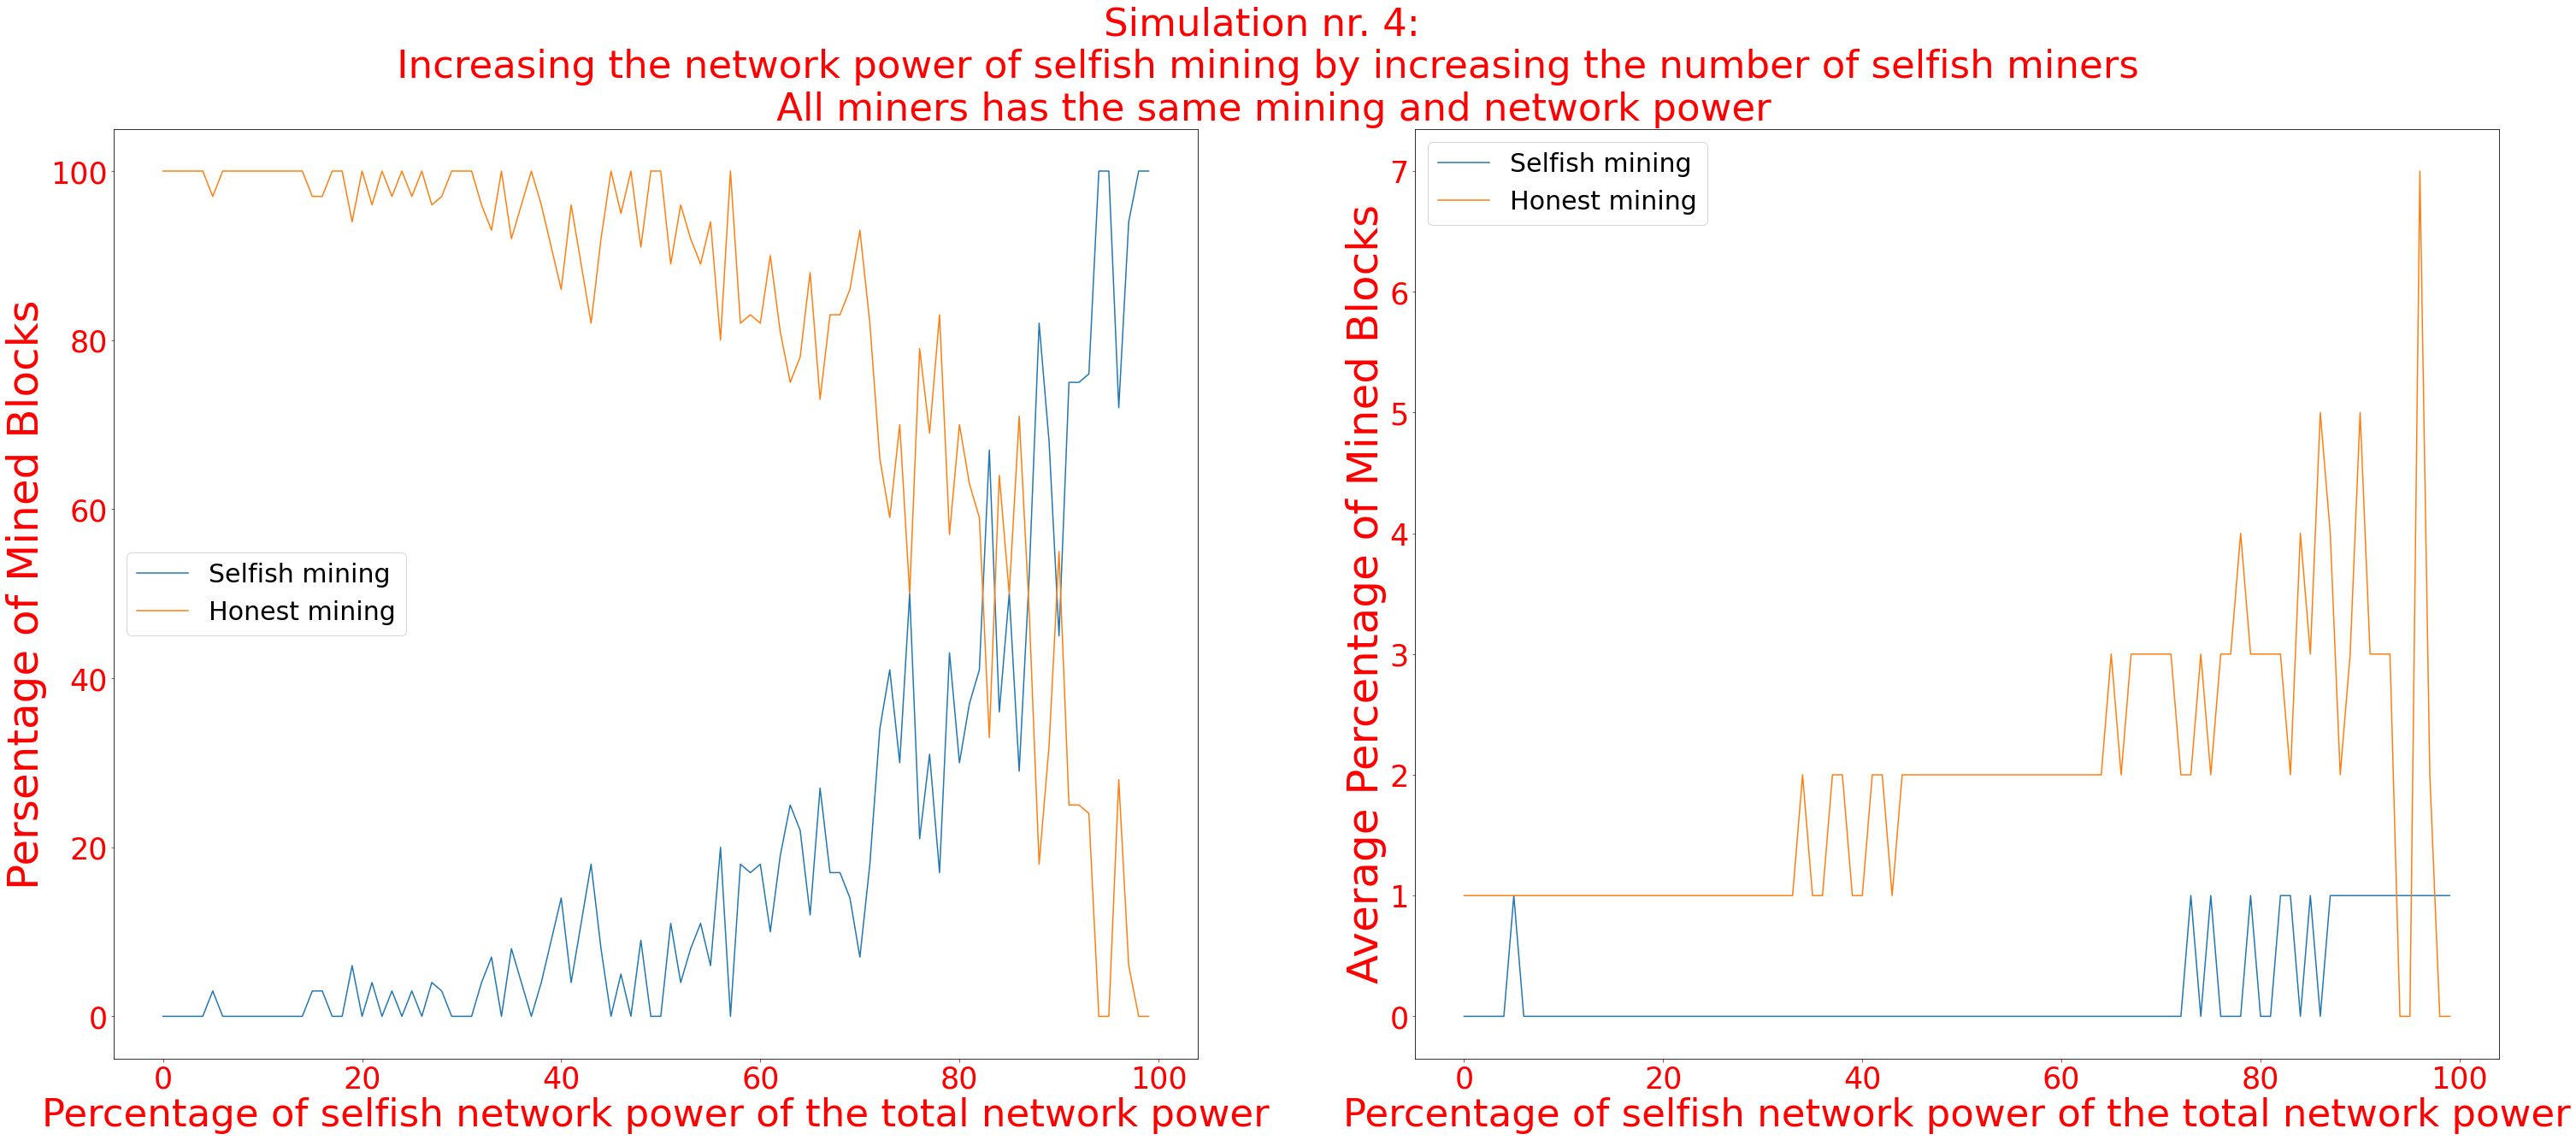

In [11]:
"""
Drawing the results of the previous simulation nr. 4
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(50,20))
fig.suptitle('Simulation nr. 4: \n Increasing the network power of selfish mining by increasing the number of selfish miners \n All miners has the same mining and network power\n', fontsize=45).set_color('red')  

axs[0].plot(selfish_power, all_total_selfish_profits, label = "Selfish mining")
axs[0].plot(selfish_power, all_total_honest_profits, label = "Honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of selfish network power of the total network power', fontsize=45).set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[0].legend(prop={"size":30})
l = plt.setp(axs[0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0].get_yticklabels(), fontsize=35)

axs[1].plot(selfish_power, all_average_selfish_profits, label = "Selfish mining")
axs[1].plot(selfish_power, all_average_honest_profits, label = "Honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish network power of the total network power', fontsize=45).set_color('red')
axs[1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[1].legend(prop={"size":30})
l = plt.setp(axs[1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1].get_yticklabels(), fontsize=35)

## Analysis and Comments on Simulation Results nr. 4
When we inrease the selfish network power by inreasing the number of selfish miners and decreasing the number of honest miners, we observe the following:

1. Selfish mining is less profitbale under around 80% network power.<br><br>

2. The competition between selfish and honest mining is high at around 80% to 90%.<br><br>

3. Selfish mining is more profitable when selfish miners have more than 90% of network power together in total.<br><br>

4. However for an average miner, it is mostly better to be an honest miner since the average profit made by honest miners is most of the time higher than it is for those selfish miners. as the average plot on the right side shows.<br><br>

### Greedy Heaviest-Observed Subtree: Simulation & Analysis<br>
## Simulation nr. 5: 
In this simulation we aim to study the effect of the GHOST strategy on selfish mining. This simulation has the following setup:

A) Total number of miners 100.

B) Total mining power of 100, each miner has a mining power of 1.

C) Total network power of 10 000, each miner has a full network power of 100.

D) Network power is random.

E) We start the simulation with 100 honest miners and 0 GHOST selfish miners

F) We run the simulation for 60 steps, at each step: 

1. Increasing the number for selfish miners follwoing the GHOST strategy by 1, and
2. Decreasing the number for honest miners by 1.

### GHOST Simulation & Analysis <br>

#### The following redesign steps was added to the previous core classes to implement GHOST mining

A) Adding a heaviestChain() method in the Blockchain class to get the chain with the most blocks in it.

B) Editing the mechanism in the Blockchain class to implement the changes in A)above.

In [12]:
class Blockchain:
    def __init__(self, genesis_data, difficulty, protocol="longest"):
        self.chain = []
        self.chain.append(Block(genesis_data))
        self.difficulty = difficulty
        self.size = 0
        self.protocol = protocol

    def lastBlock(self):
      if self.protocol == "longest":
        return self.longestChain()
      else:
        return self.heaviestChain(self.chain[0])
    
    def longestChain(self): 
      max = self.chain[0]
      for block in self.chain:
        if block.height > max.height:
          max = block
      return max

    def heaviestChain(self, root):
      if len(root.children) == 0:
        return root
      else:
        max = root.children[0]
        maxChilds = self.numberOfBlocksInSubtree(max)
        for block in root.children:
          tmp = self.numberOfBlocksInSubtree(block)
          if tmp > maxChilds:
            max = block
            maxChilds = tmp
        return self.heaviestChain(max)

    def numberOfBlocksInSubtree(self, block):
      if len(block.children) == 0:
        return 1
      else:
        sum = 0
        for b in block.children:
          sum += self.numberOfBlocksInSubtree(b)
        return 1 + sum

    def add(self, newBlock):
        self.chain.append(newBlock)
        newBlock.previous.children.append(newBlock)
        self.size +=1
        
    def checkMiner(self, miner):
        last = self.longestChain()
        count = 0
        while last!=None:
            if last.creator == miner:
                count += 1
            last = last.previous
        return count

In [15]:
def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain):
    miners = []
    remaining_mining_power = total_mining_power
    remaining_network_power = total_network_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            if remaining_mining_power < 0:
                mining_power = 0
            else:
                mining_power = 1
            remaining_mining_power -= mining_power
        
        network_power = 100 # random network power when doing GHOST Simulation
        if type_of_minors == "honest":
            miner = Miner(mining_power, network_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "selfish":
            miner = SelfishMiner(mining_power, network_power, "Selfish", f"Selfish miner nr. {len(miners)+1}", blockchain)
        
        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 5, se table at the head of this notebook for summary details
"""
output = True
all_total_selfish_profits = []
all_total_honest_profits = []
all_average_selfish_profits = []
all_average_honest_profits = []
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

print("Simulating varying network power between miners with")
print("-> equal mining power for each miner")
print("-> and varying the number of honest and selfish miners at each simulation")
print("")

for i in sim_range_selfish:
    num_of_selfish_miners = i
    num_of_honest_miners = 100-i
    
    total_mining_power = 100
    honest_mining_power_share = round(num_of_honest_miners/total_mining_power, 2)
    selfish_mining_power_share = round(num_of_selfish_miners/total_mining_power, 2)
    honest_mining_power = round(total_mining_power * honest_mining_power_share)
    selfish_mining_power = round(total_mining_power * selfish_mining_power_share)
    
    """
    total_network_power = 10000
    honest_network_power_share = round(num_of_honest_miners/total_network_power, 2)
    selfish_network_power_share = round(num_of_selfish_miners/total_network_power, 2)
    honest_network_power = round(total_network_power * honest_network_power_share)
    selfish_network_power = round(total_network_power * selfish_network_power_share)

    """

    bc = Blockchain("0" , 7)
    
    honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc)
    
    selfish_miners = make_miners("selfish", num_of_selfish_miners, selfish_mining_power, bc)
        
    if output:
        print(f"Running simulation with:")
        print(f"-> {len(honest_miners)} honest minors having {honest_network_power}% of total networking power and {honest_mining_power}% of total mining power")
        print(f"-> {len(selfish_miners)} selfish minors having {selfish_network_power}% of total networking power and {selfish_mining_power}% of total mining power")
        print("...")
        
    selfish_profits, honest_profits = simulate_selfish_mining(bc, honest_miners, selfish_miners)
    sum_selfish_profit = round(sum(selfish_profits), 2)
    sum_honest_profit = round(sum(honest_profits), 2)
    all_total_selfish_profits.append(sum_selfish_profit*100)
    all_total_honest_profits.append(sum_honest_profit*100)
    
    if len(selfish_profits) != 0:
        average_selfish_profit = sum(selfish_profits) / len(selfish_profits)
    else:
        average_selfish_profit = 0
    all_average_selfish_profits.append(average_selfish_profit*100)  
    
    if len(honest_profits) != 0:
        average_honest_profit = sum(honest_profits) / len(honest_profits)
    else:
        average_honest_profit = 0
    all_average_honest_profits.append(average_honest_profit*100)
    
    if output:
        print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
        print(f"Total Percentage Sum of Selfish Profit: {sum_selfish_profit}, Average: {average_selfish_profit}")
        print(f"Total Percentage Sum of Profit (Honest+Selfish): {round(sum_selfish_profit+sum_honest_profit)}")
        print()

Simulating varying network power between miners with
-> equal mining power for each miner
-> and varying the number of honest and selfish miners at each simulation

Running simulation with:
-> 100 honest minors having 1% of total networking power and 100% of total mining power
-> 0 selfish minors having 99% of total networking power and 0% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.009999999999999992
Total Percentage Sum of Selfish Profit: 0, Average: 0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 99 honest minors having 1% of total networking power and 99% of total mining power
-> 1 selfish minors having 99% of total networking power and 1% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.010101010101010102
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 98 honest minors having 1% of total net

Total Percentage Sum of Honest Profit: 1.0, Average: 0.012658227848101266
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 78 honest minors having 1% of total networking power and 78% of total mining power
-> 22 selfish minors having 99% of total networking power and 22% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.012820512820512824
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 77 honest minors having 1% of total networking power and 77% of total mining power
-> 23 selfish minors having 99% of total networking power and 23% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.012987012987012993
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 76 honest mino

Total Percentage Sum of Honest Profit: 0.95, Average: 0.01642036124794746
Total Percentage Sum of Selfish Profit: 0.05, Average: 0.0011337868480725624
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 57 honest minors having 1% of total networking power and 57% of total mining power
-> 43 selfish minors having 99% of total networking power and 43% of total mining power
...
Total Percentage Sum of Honest Profit: 0.96, Average: 0.016781083142639198
Total Percentage Sum of Selfish Profit: 0.04, Average: 0.0010111223458038423
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 56 honest minors having 1% of total networking power and 56% of total mining power
-> 44 selfish minors having 99% of total networking power and 44% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.017857142857142853
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total Percentage Sum of Profit (Honest+Selfish): 1

Run

Total Percentage Sum of Honest Profit: 0.83, Average: 0.02252252252252253
Total Percentage Sum of Selfish Profit: 0.17, Average: 0.0026455026455026454
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 36 honest minors having 1% of total networking power and 36% of total mining power
-> 64 selfish minors having 99% of total networking power and 64% of total mining power
...
Total Percentage Sum of Honest Profit: 0.86, Average: 0.023809523809523815
Total Percentage Sum of Selfish Profit: 0.14, Average: 0.002232142857142857
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 35 honest minors having 1% of total networking power and 35% of total mining power
-> 65 selfish minors having 99% of total networking power and 65% of total mining power
...
Total Percentage Sum of Honest Profit: 0.87, Average: 0.02476190476190476
Total Percentage Sum of Selfish Profit: 0.13, Average: 0.0020512820512820513
Total Percentage Sum of Profit (Hones

Total Percentage Sum of Honest Profit: 0.52, Average: 0.032499999999999994
Total Percentage Sum of Selfish Profit: 0.48, Average: 0.005714285714285715
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 15 honest minors having 1% of total networking power and 15% of total mining power
-> 85 selfish minors having 99% of total networking power and 85% of total mining power
...
Total Percentage Sum of Honest Profit: 0.56, Average: 0.03703703703703704
Total Percentage Sum of Selfish Profit: 0.44, Average: 0.00522875816993464
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 14 honest minors having 1% of total networking power and 14% of total mining power
-> 86 selfish minors having 99% of total networking power and 86% of total mining power
...
Total Percentage Sum of Honest Profit: 0.45, Average: 0.03246753246753247
Total Percentage Sum of Selfish Profit: 0.55, Average: 0.0063424947145877385
Total Percentage Sum of Profit (Honest+

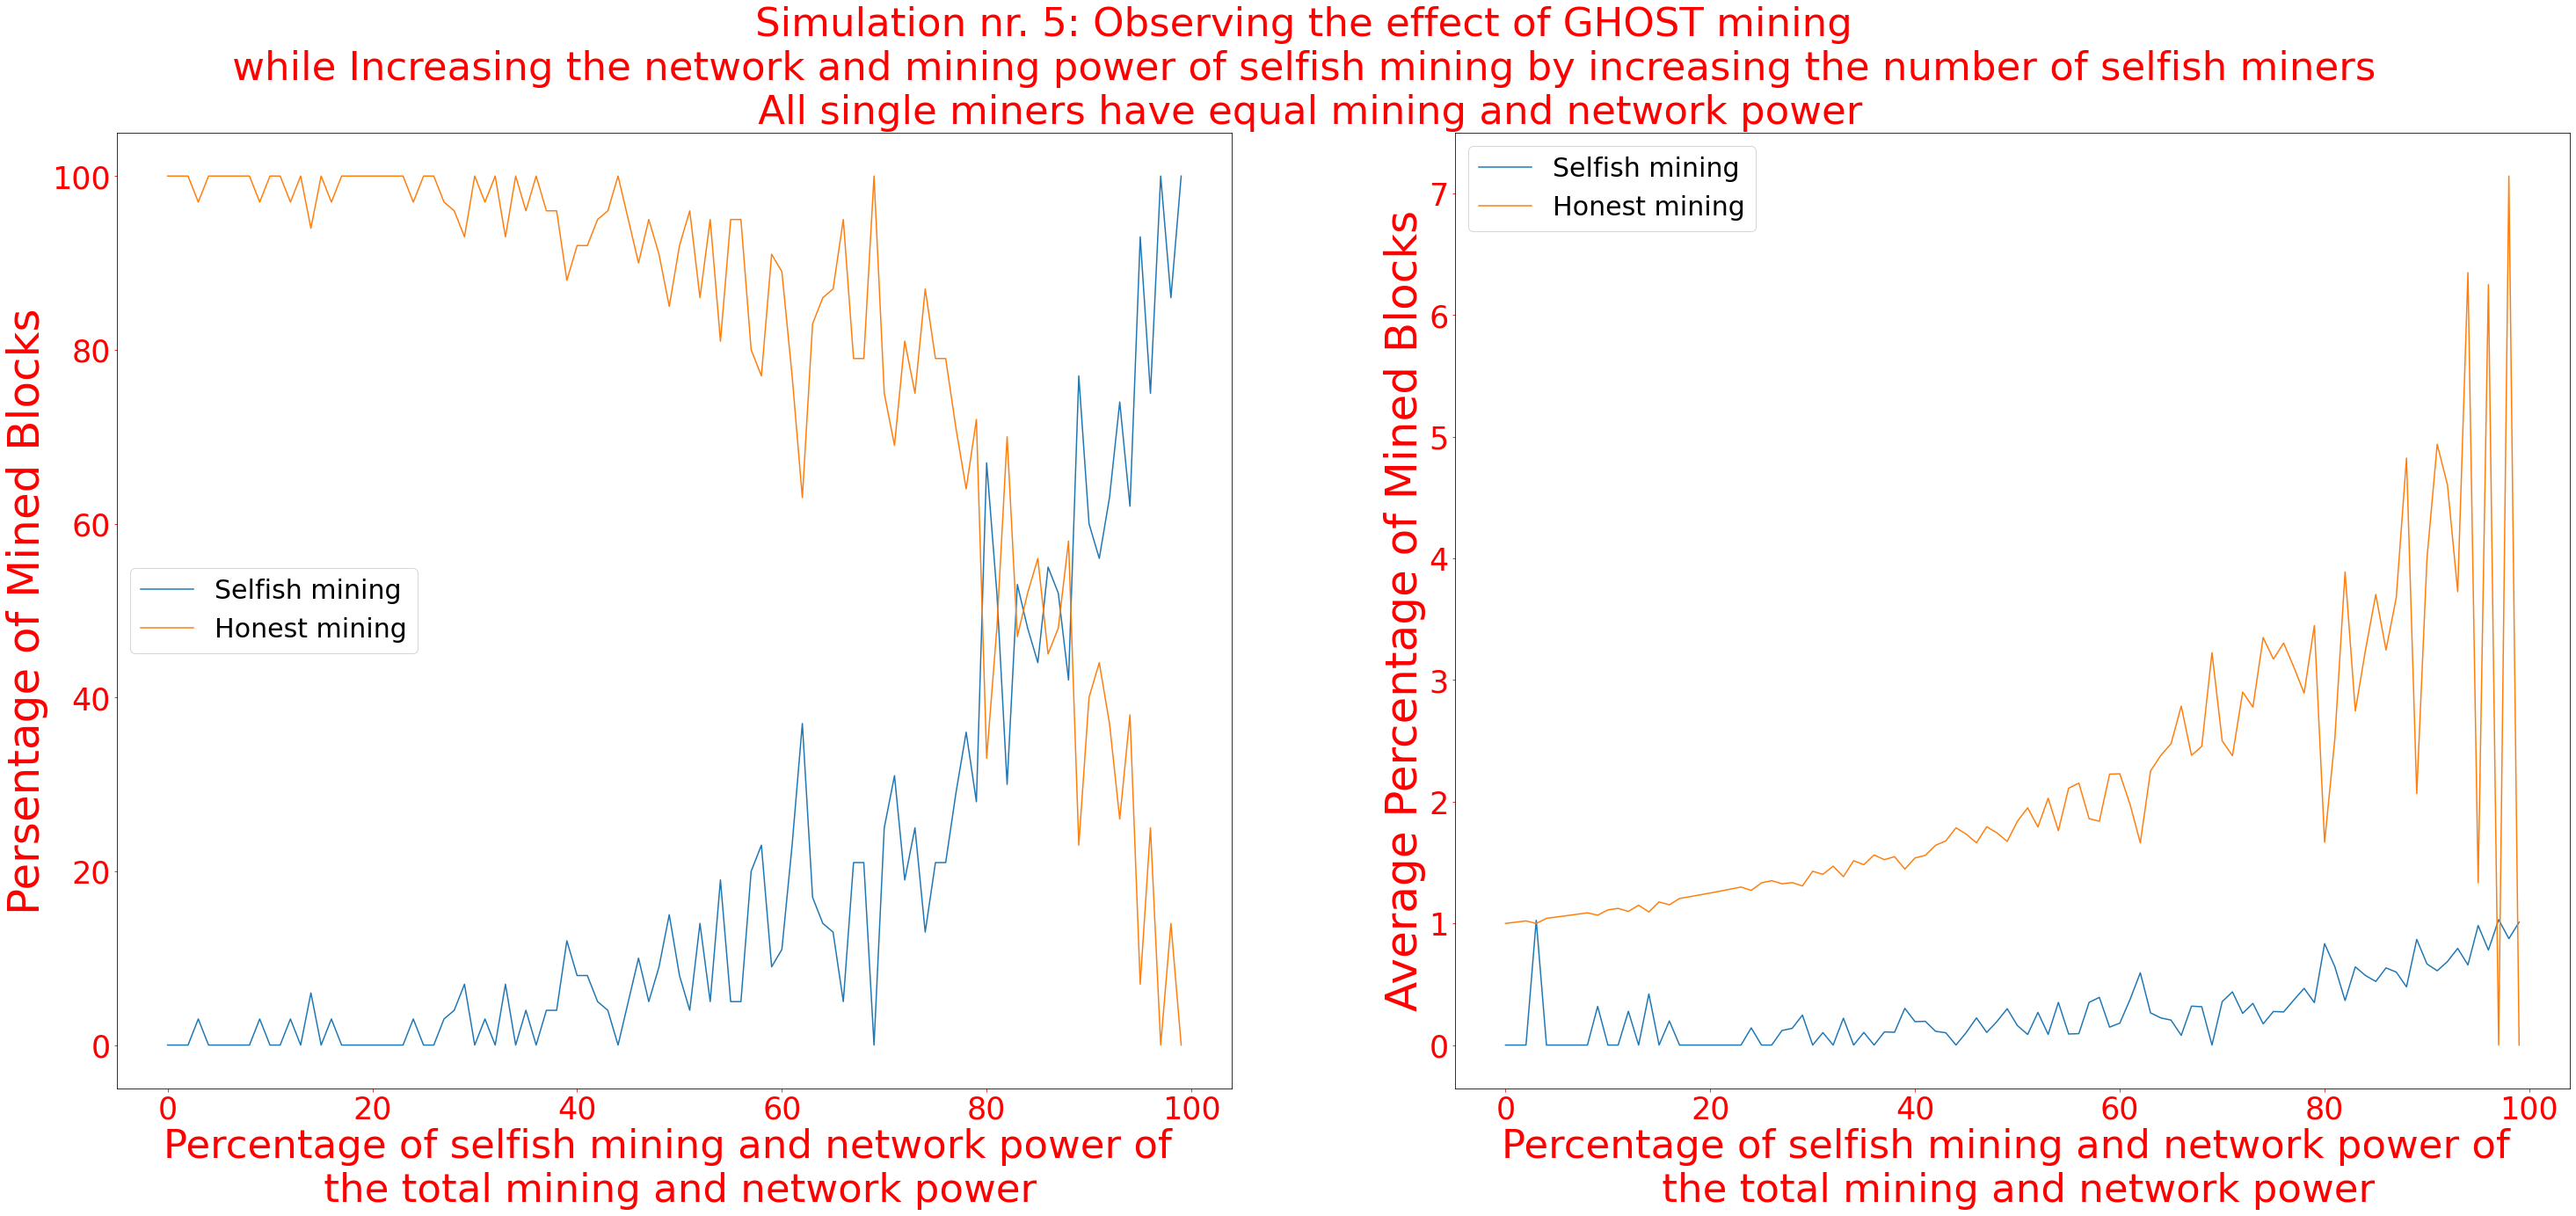

In [16]:
"""
Drawing the results of the previous simulation nr. 5
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(50,20))
fig.suptitle('Simulation nr. 5: Observing the effect of GHOST mining\n while Increasing the network and mining power of selfish mining by increasing the number of selfish miners \n All single miners have equal mining and network power\n', fontsize=45).set_color('red')  

axs[0].plot(selfish_power, all_total_selfish_profits, label = "Selfish mining")
axs[0].plot(selfish_power, all_total_honest_profits, label = "Honest mining")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[0].legend(prop={"size":30})
l = plt.setp(axs[0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0].get_yticklabels(), fontsize=35)

axs[1].plot(selfish_power, all_average_selfish_profits, label = "Selfish mining")
axs[1].plot(selfish_power, all_average_honest_profits, label = "Honest mining")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[1].legend(prop={"size":30})
l = plt.setp(axs[1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1].get_yticklabels(), fontsize=35)

## Analysis and Comments on Simulation Results nr. 5
When we observe the effect of the GHOST mining while inreasing the selfish mining and network power by increasing the number of GHOST selfish miners and decreasing the number of honest miners, we notice the following:
1. Selfish miners following the GHOST strategy have to get hold on more than 80% of both network and mining power to be start making more profit then honest miners.
2. On average, single honest miners makes more profit than their counter GHOST selfish miners, as shown in the right plot above.

### Stubborn Mining: Simulation & Analysis<br>
## Simulation nr. 6: 
In this simulation we aim to study the effect of the Stubborn mining strategy. This simulation has the following setup:

A) Total number of miners 100.

B) Total mining power of 100, each miner has a mining power of 1.

C) Total network power of 10 000, each miner has a network power of 1.

D) Network power is random.

E) We start the simulation with 100 honest miners and 0 GHOST selfish miners

F) We run the simulation for 60 steps, at each step: 

1. Increasing the number for selfish miners follwoing the GHOST strategy by 1, and
2. Decreasing the number for honest miners by 1.

### Stubborn Simulation & Analysis <br>

#### The following redesign steps was added to the previous core classes to implement stubborn mining

A)Editing the miner class for honest mining, by defining a parameter for a block difference between the longest blockchain and the stubborn miner's blockchain. 

B) If the difference between the longest blockchain and the stubborn miner's blockchain becomes more than the given block difference in either direction, then the stubborn miner should start again at the top of the longest blockchain.

In [18]:
class StubbornMiner:
    def __init__(self, miningPower, networkingPower, miner_type, name, blockchain=None, block_difference=None):    
        self.block_difference = block_difference
        self.miningPower = miningPower
        self.networkingPower = networkingPower
        self.miner_type = miner_type
        self.nonce = random.randint(0,100000)
        self.name = name
        self.blockchain = blockchain
        if self.blockchain != None:
            self.lastBlock = blockchain.longestChain()
  
    def UpdateLast(self):
        latest = self.blockchain.longestChain()
        if latest.height-self.lastBlock.height >= self.block_difference or self.lastBlock.height-latest.height >= self.block_difference:
            self.lastBlock = latest
        
    def PoWSolver(self):
        for i in range (0 , self.miningPower):
            newBlock = Block(str(self.blockchain.size), self, self.lastBlock, self.nonce)
            h = newBlock.hash_block()
            count = numberOfInitZeros(h)
            if count >= bc.difficulty:
                self.blockchain.add(newBlock)
                self.lastBlock = newBlock
            self.nonce += 1

In [24]:
def make_miners(type_of_minors, num_of_miners, total_mining_power, blockchain, block_difference):
    miners = []
    remaining_mining_power = total_mining_power
    remaining_network_power = total_network_power
    
    while len(miners) < num_of_miners:
        if len(miners) == num_of_miners-1:
            mining_power = remaining_mining_power
        else:
            mining_power = round(total_mining_power/num_of_miners)
            if remaining_mining_power < 0:
                mining_power = 0
            else:
                mining_power = 1
            remaining_mining_power -= mining_power
        
        network_power = 100
        if type_of_minors == "honest":
            miner = Miner(mining_power, network_power, "Honest", f"Honest miner nr. {len(miners)+1}", blockchain)
        elif type_of_minors == "stubborn":
            miner = StubbornMiner(mining_power, network_power, "Stubborn Selfish", f"Stubborn Selfish miner nr. {len(miners)+1}", blockchain, block_difference)   
        
        miners.append(miner)
        
    return miners

"""
The code below runs simulation nr. 6, se table at the head of this notebook for summary details
"""
output = True
all_total_selfish_profits = [[], [], []]
all_total_honest_profits = [[], [], []]
all_average_selfish_profits = [[], [], []]
all_average_honest_profits = [[], [], []]
sim_range_selfish = range(0, 100, 1)
sim_range_honest = range(100, 0, -1)

print("Simulating the effect of stubborn mining strategy on selfish mining")
print("-> equal mining and network power for each miner")
print("-> and varying the number of honest and selfish miners at each simulation")
print("")

for block_difference in range(1, 4, 1):
    print()
    print(f"**********Running Stubborn mining simulation for: {block_difference} in block difference************")
    print()
    
    for i in sim_range_selfish:
        num_of_selfish_miners = i
        num_of_honest_miners = 100-i

        total_mining_power = 100
        honest_mining_power_share = round(num_of_honest_miners/total_mining_power, 2)
        selfish_mining_power_share = round(num_of_selfish_miners/total_mining_power, 2)
        honest_mining_power = round(total_mining_power * honest_mining_power_share)
        selfish_mining_power = round(total_mining_power * selfish_mining_power_share)

        bc = Blockchain("0" , 7)

        honest_miners = make_miners("honest", num_of_honest_miners, honest_mining_power, bc, 0)

        selfish_miners = make_miners("stubborn", num_of_selfish_miners, selfish_mining_power, bc, block_difference)

        if output:
            print(f"Running simulation with:")
            print(f"-> {len(honest_miners)} honest minors having {honest_network_power}% of total networking power and {honest_mining_power}% of total mining power")
            print(f"-> {len(selfish_miners)} selfish minors having {selfish_network_power}% of total networking power and {selfish_mining_power}% of total mining power")
            print("...")

        selfish_profits, honest_profits = simulate_selfish_mining(bc, honest_miners, selfish_miners)
        sum_selfish_profit = round(sum(selfish_profits), 2)
        sum_honest_profit = round(sum(honest_profits), 2)
        all_total_selfish_profits[block_difference-1].append(sum_selfish_profit*100)
        all_total_honest_profits[block_difference-1].append(sum_honest_profit*100)

        if len(selfish_profits) != 0:
            average_selfish_profit = sum(selfish_profits) / len(selfish_profits)
        else:
            average_selfish_profit = 0
        all_average_selfish_profits[block_difference-1].append(average_selfish_profit*100)  

        if len(honest_profits) != 0:
            average_honest_profit = sum(honest_profits) / len(honest_profits)
        else:
            average_honest_profit = 0
        all_average_honest_profits[block_difference-1].append(average_honest_profit*100)

        if output:
            print(f"Total Percentage Sum of Honest Profit: {sum_honest_profit}, Average: {average_honest_profit}")
            print(f"Total Percentage Sum of Selfish Profit: {sum_selfish_profit}, Average: {average_selfish_profit}")
            print(f"Total Percentage Sum of Profit (Honest+Selfish): {round(sum_selfish_profit+sum_honest_profit)}")
            print()

Simulating the effect of stubborn mining strategy on selfish mining
-> equal mining and network power for each miner
-> and varying the number of honest and selfish miners at each simulation


**********Running Stubborn mining simulation for: 1 in block difference************

Running simulation with:
-> 100 honest minors having 1% of total networking power and 100% of total mining power
-> 0 selfish minors having 99% of total networking power and 0% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.009999999999999992
Total Percentage Sum of Selfish Profit: 0, Average: 0
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 99 honest minors having 1% of total networking power and 99% of total mining power
-> 1 selfish minors having 99% of total networking power and 1% of total mining power
...
Total Percentage Sum of Honest Profit: 1.0, Average: 0.010101010101010098
Total Percentage Sum of Selfish Profit: 0.0, Average: 0.0
Total 

Total Percentage Sum of Honest Profit: 0.75, Average: 0.009333333333333327
Total Percentage Sum of Selfish Profit: 0.25, Average: 0.012666666666666668
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 79 honest minors having 1% of total networking power and 79% of total mining power
-> 21 selfish minors having 99% of total networking power and 21% of total mining power
...
Total Percentage Sum of Honest Profit: 0.69, Average: 0.008735960064182561
Total Percentage Sum of Selfish Profit: 0.31, Average: 0.014755197853789401
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 78 honest minors having 1% of total networking power and 78% of total mining power
-> 22 selfish minors having 99% of total networking power and 22% of total mining power
...
Total Percentage Sum of Honest Profit: 0.71, Average: 0.009129759129759126
Total Percentage Sum of Selfish Profit: 0.29, Average: 0.013085399449035811
Total Percentage Sum of Profit (Hones

Total Percentage Sum of Honest Profit: 0.59, Average: 0.010071235568656349
Total Percentage Sum of Selfish Profit: 0.41, Average: 0.009897490279250623
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 58 honest minors having 1% of total networking power and 58% of total mining power
-> 42 selfish minors having 99% of total networking power and 42% of total mining power
...
Total Percentage Sum of Honest Profit: 0.34, Average: 0.005918682449819863
Total Percentage Sum of Selfish Profit: 0.66, Average: 0.01563610518834399
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 57 honest minors having 1% of total networking power and 57% of total mining power
-> 43 selfish minors having 99% of total networking power and 43% of total mining power
...
Total Percentage Sum of Honest Profit: 0.49, Average: 0.008513931888544893
Total Percentage Sum of Selfish Profit: 0.51, Average: 0.011969904240766075
Total Percentage Sum of Profit (Honest

Total Percentage Sum of Honest Profit: 0.27, Average: 0.0071428571428571435
Total Percentage Sum of Selfish Profit: 0.73, Average: 0.011751152073732713
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 37 honest minors having 1% of total networking power and 37% of total mining power
-> 63 selfish minors having 99% of total networking power and 63% of total mining power
...
Total Percentage Sum of Honest Profit: 0.41, Average: 0.0111969111969112
Total Percentage Sum of Selfish Profit: 0.59, Average: 0.00929705215419501
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 36 honest minors having 1% of total networking power and 36% of total mining power
-> 64 selfish minors having 99% of total networking power and 64% of total mining power
...
Total Percentage Sum of Honest Profit: 0.26, Average: 0.007352941176470588
Total Percentage Sum of Selfish Profit: 0.74, Average: 0.011488970588235285
Total Percentage Sum of Profit (Honest+

Total Percentage Sum of Honest Profit: 0.11, Average: 0.0066280033140016575
Total Percentage Sum of Selfish Profit: 0.89, Average: 0.01069064992363821
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 16 honest minors having 1% of total networking power and 16% of total mining power
-> 84 selfish minors having 99% of total networking power and 84% of total mining power
...
Total Percentage Sum of Honest Profit: 0.19, Average: 0.011986301369863013
Total Percentage Sum of Selfish Profit: 0.81, Average: 0.00962165688193086
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 15 honest minors having 1% of total networking power and 15% of total mining power
-> 85 selfish minors having 99% of total networking power and 85% of total mining power
...
Total Percentage Sum of Honest Profit: 0.09, Average: 0.006153846153846154
Total Percentage Sum of Selfish Profit: 0.91, Average: 0.0106787330316742
Total Percentage Sum of Profit (Honest+S

Total Percentage Sum of Honest Profit: 0.98, Average: 0.010258838383838377
Total Percentage Sum of Selfish Profit: 0.02, Average: 0.003787878787878788
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 95 honest minors having 1% of total networking power and 95% of total mining power
-> 5 selfish minors having 99% of total networking power and 5% of total mining power
...
Total Percentage Sum of Honest Profit: 0.97, Average: 0.010192147034252287
Total Percentage Sum of Selfish Profit: 0.03, Average: 0.006349206349206349
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 94 honest minors having 1% of total networking power and 94% of total mining power
-> 6 selfish minors having 99% of total networking power and 6% of total mining power
...
Total Percentage Sum of Honest Profit: 0.97, Average: 0.01034278959810874
Total Percentage Sum of Selfish Profit: 0.03, Average: 0.004629629629629629
Total Percentage Sum of Profit (Honest+Sel

Total Percentage Sum of Honest Profit: 0.84, Average: 0.011182795698924726
Total Percentage Sum of Selfish Profit: 0.16, Average: 0.006451612903225806
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 74 honest minors having 1% of total networking power and 74% of total mining power
-> 26 selfish minors having 99% of total networking power and 26% of total mining power
...
Total Percentage Sum of Honest Profit: 0.89, Average: 0.012080262080262073
Total Percentage Sum of Selfish Profit: 0.11, Average: 0.004079254079254079
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 73 honest minors having 1% of total networking power and 73% of total mining power
-> 27 selfish minors having 99% of total networking power and 27% of total mining power
...
Total Percentage Sum of Honest Profit: 0.79, Average: 0.010792860107928594
Total Percentage Sum of Selfish Profit: 0.21, Average: 0.007856341189674522
Total Percentage Sum of Profit (Hones

Total Percentage Sum of Honest Profit: 0.66, Average: 0.012152777777777778
Total Percentage Sum of Selfish Profit: 0.34, Average: 0.007472826086956522
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 53 honest minors having 1% of total networking power and 53% of total mining power
-> 47 selfish minors having 99% of total networking power and 47% of total mining power
...
Total Percentage Sum of Honest Profit: 0.63, Average: 0.011792452830188682
Total Percentage Sum of Selfish Profit: 0.37, Average: 0.007978723404255317
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 52 honest minors having 1% of total networking power and 52% of total mining power
-> 48 selfish minors having 99% of total networking power and 48% of total mining power
...
Total Percentage Sum of Honest Profit: 0.45, Average: 0.008708272859216255
Total Percentage Sum of Selfish Profit: 0.55, Average: 0.01139937106918239
Total Percentage Sum of Profit (Honest

Total Percentage Sum of Honest Profit: 0.52, Average: 0.015810276679841893
Total Percentage Sum of Selfish Profit: 0.48, Average: 0.007138221933809214
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 32 honest minors having 1% of total networking power and 32% of total mining power
-> 68 selfish minors having 99% of total networking power and 68% of total mining power
...
Total Percentage Sum of Honest Profit: 0.42, Average: 0.01302083333333333
Total Percentage Sum of Selfish Profit: 0.58, Average: 0.008578431372549019
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 31 honest minors having 1% of total networking power and 31% of total mining power
-> 69 selfish minors having 99% of total networking power and 69% of total mining power
...
Total Percentage Sum of Honest Profit: 0.65, Average: 0.020833333333333336
Total Percentage Sum of Selfish Profit: 0.35, Average: 0.005132850241545893
Total Percentage Sum of Profit (Honest

Total Percentage Sum of Honest Profit: 0.24, Average: 0.02027027027027027
Total Percentage Sum of Selfish Profit: 0.76, Average: 0.0085995085995086
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 11 honest minors having 1% of total networking power and 11% of total mining power
-> 89 selfish minors having 99% of total networking power and 89% of total mining power
...
Total Percentage Sum of Honest Profit: 0.3, Average: 0.02748414376321353
Total Percentage Sum of Selfish Profit: 0.7, Average: 0.007839038411288215
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 10 honest minors having 1% of total networking power and 10% of total mining power
-> 90 selfish minors having 99% of total networking power and 90% of total mining power
...
Total Percentage Sum of Honest Profit: 0.15, Average: 0.015384615384615382
Total Percentage Sum of Selfish Profit: 0.85, Average: 0.009401709401709405
Total Percentage Sum of Profit (Honest+Self

Total Percentage Sum of Honest Profit: 0.96, Average: 0.01049696572084632
Total Percentage Sum of Selfish Profit: 0.04, Average: 0.004975124378109453
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 90 honest minors having 1% of total networking power and 90% of total mining power
-> 10 selfish minors having 99% of total networking power and 10% of total mining power
...
Total Percentage Sum of Honest Profit: 0.94, Average: 0.01047619047619047
Total Percentage Sum of Selfish Profit: 0.06, Average: 0.005714285714285714
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 89 honest minors having 1% of total networking power and 89% of total mining power
-> 11 selfish minors having 99% of total networking power and 11% of total mining power
...
Total Percentage Sum of Honest Profit: 0.98, Average: 0.011048689138576784
Total Percentage Sum of Selfish Profit: 0.02, Average: 0.0015151515151515152
Total Percentage Sum of Profit (Honest

Total Percentage Sum of Honest Profit: 0.86, Average: 0.012337662337662331
Total Percentage Sum of Selfish Profit: 0.14, Average: 0.004545454545454545
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 69 honest minors having 1% of total networking power and 69% of total mining power
-> 31 selfish minors having 99% of total networking power and 31% of total mining power
...
Total Percentage Sum of Honest Profit: 0.81, Average: 0.011790714812085476
Total Percentage Sum of Selfish Profit: 0.19, Average: 0.006014215418261346
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 68 honest minors having 1% of total networking power and 68% of total mining power
-> 32 selfish minors having 99% of total networking power and 32% of total mining power
...
Total Percentage Sum of Honest Profit: 0.82, Average: 0.01203208556149733
Total Percentage Sum of Selfish Profit: 0.18, Average: 0.005681818181818182
Total Percentage Sum of Profit (Honest

Total Percentage Sum of Honest Profit: 0.76, Average: 0.015510204081632659
Total Percentage Sum of Selfish Profit: 0.24, Average: 0.004705882352941176
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 48 honest minors having 1% of total networking power and 48% of total mining power
-> 52 selfish minors having 99% of total networking power and 52% of total mining power
...
Total Percentage Sum of Honest Profit: 0.79, Average: 0.016426282051282052
Total Percentage Sum of Selfish Profit: 0.21, Average: 0.004068047337278106
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 47 honest minors having 1% of total networking power and 47% of total mining power
-> 53 selfish minors having 99% of total networking power and 53% of total mining power
...
Total Percentage Sum of Honest Profit: 0.71, Average: 0.015197568389057756
Total Percentage Sum of Selfish Profit: 0.29, Average: 0.005390835579514824
Total Percentage Sum of Profit (Hones

Total Percentage Sum of Honest Profit: 0.57, Average: 0.020270270270270275
Total Percentage Sum of Selfish Profit: 0.43, Average: 0.006006006006006006
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 27 honest minors having 1% of total networking power and 27% of total mining power
-> 73 selfish minors having 99% of total networking power and 73% of total mining power
...
Total Percentage Sum of Honest Profit: 0.53, Average: 0.01954732510288066
Total Percentage Sum of Selfish Profit: 0.47, Average: 0.006468797564687977
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 26 honest minors having 1% of total networking power and 26% of total mining power
-> 74 selfish minors having 99% of total networking power and 74% of total mining power
...
Total Percentage Sum of Honest Profit: 0.51, Average: 0.019699812382739216
Total Percentage Sum of Selfish Profit: 0.49, Average: 0.006591957811470009
Total Percentage Sum of Profit (Honest

Total Percentage Sum of Honest Profit: 0.32, Average: 0.046218487394957986
Total Percentage Sum of Selfish Profit: 0.68, Average: 0.007273877292852626
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 6 honest minors having 1% of total networking power and 6% of total mining power
-> 94 selfish minors having 99% of total networking power and 94% of total mining power
...
Total Percentage Sum of Honest Profit: 0.22, Average: 0.037037037037037035
Total Percentage Sum of Selfish Profit: 0.78, Average: 0.008274231678486997
Total Percentage Sum of Profit (Honest+Selfish): 1

Running simulation with:
-> 5 honest minors having 1% of total networking power and 5% of total mining power
-> 95 selfish minors having 99% of total networking power and 95% of total mining power
...
Total Percentage Sum of Honest Profit: 0.05, Average: 0.00909090909090909
Total Percentage Sum of Selfish Profit: 0.95, Average: 0.01004784688995215
Total Percentage Sum of Profit (Honest+Self

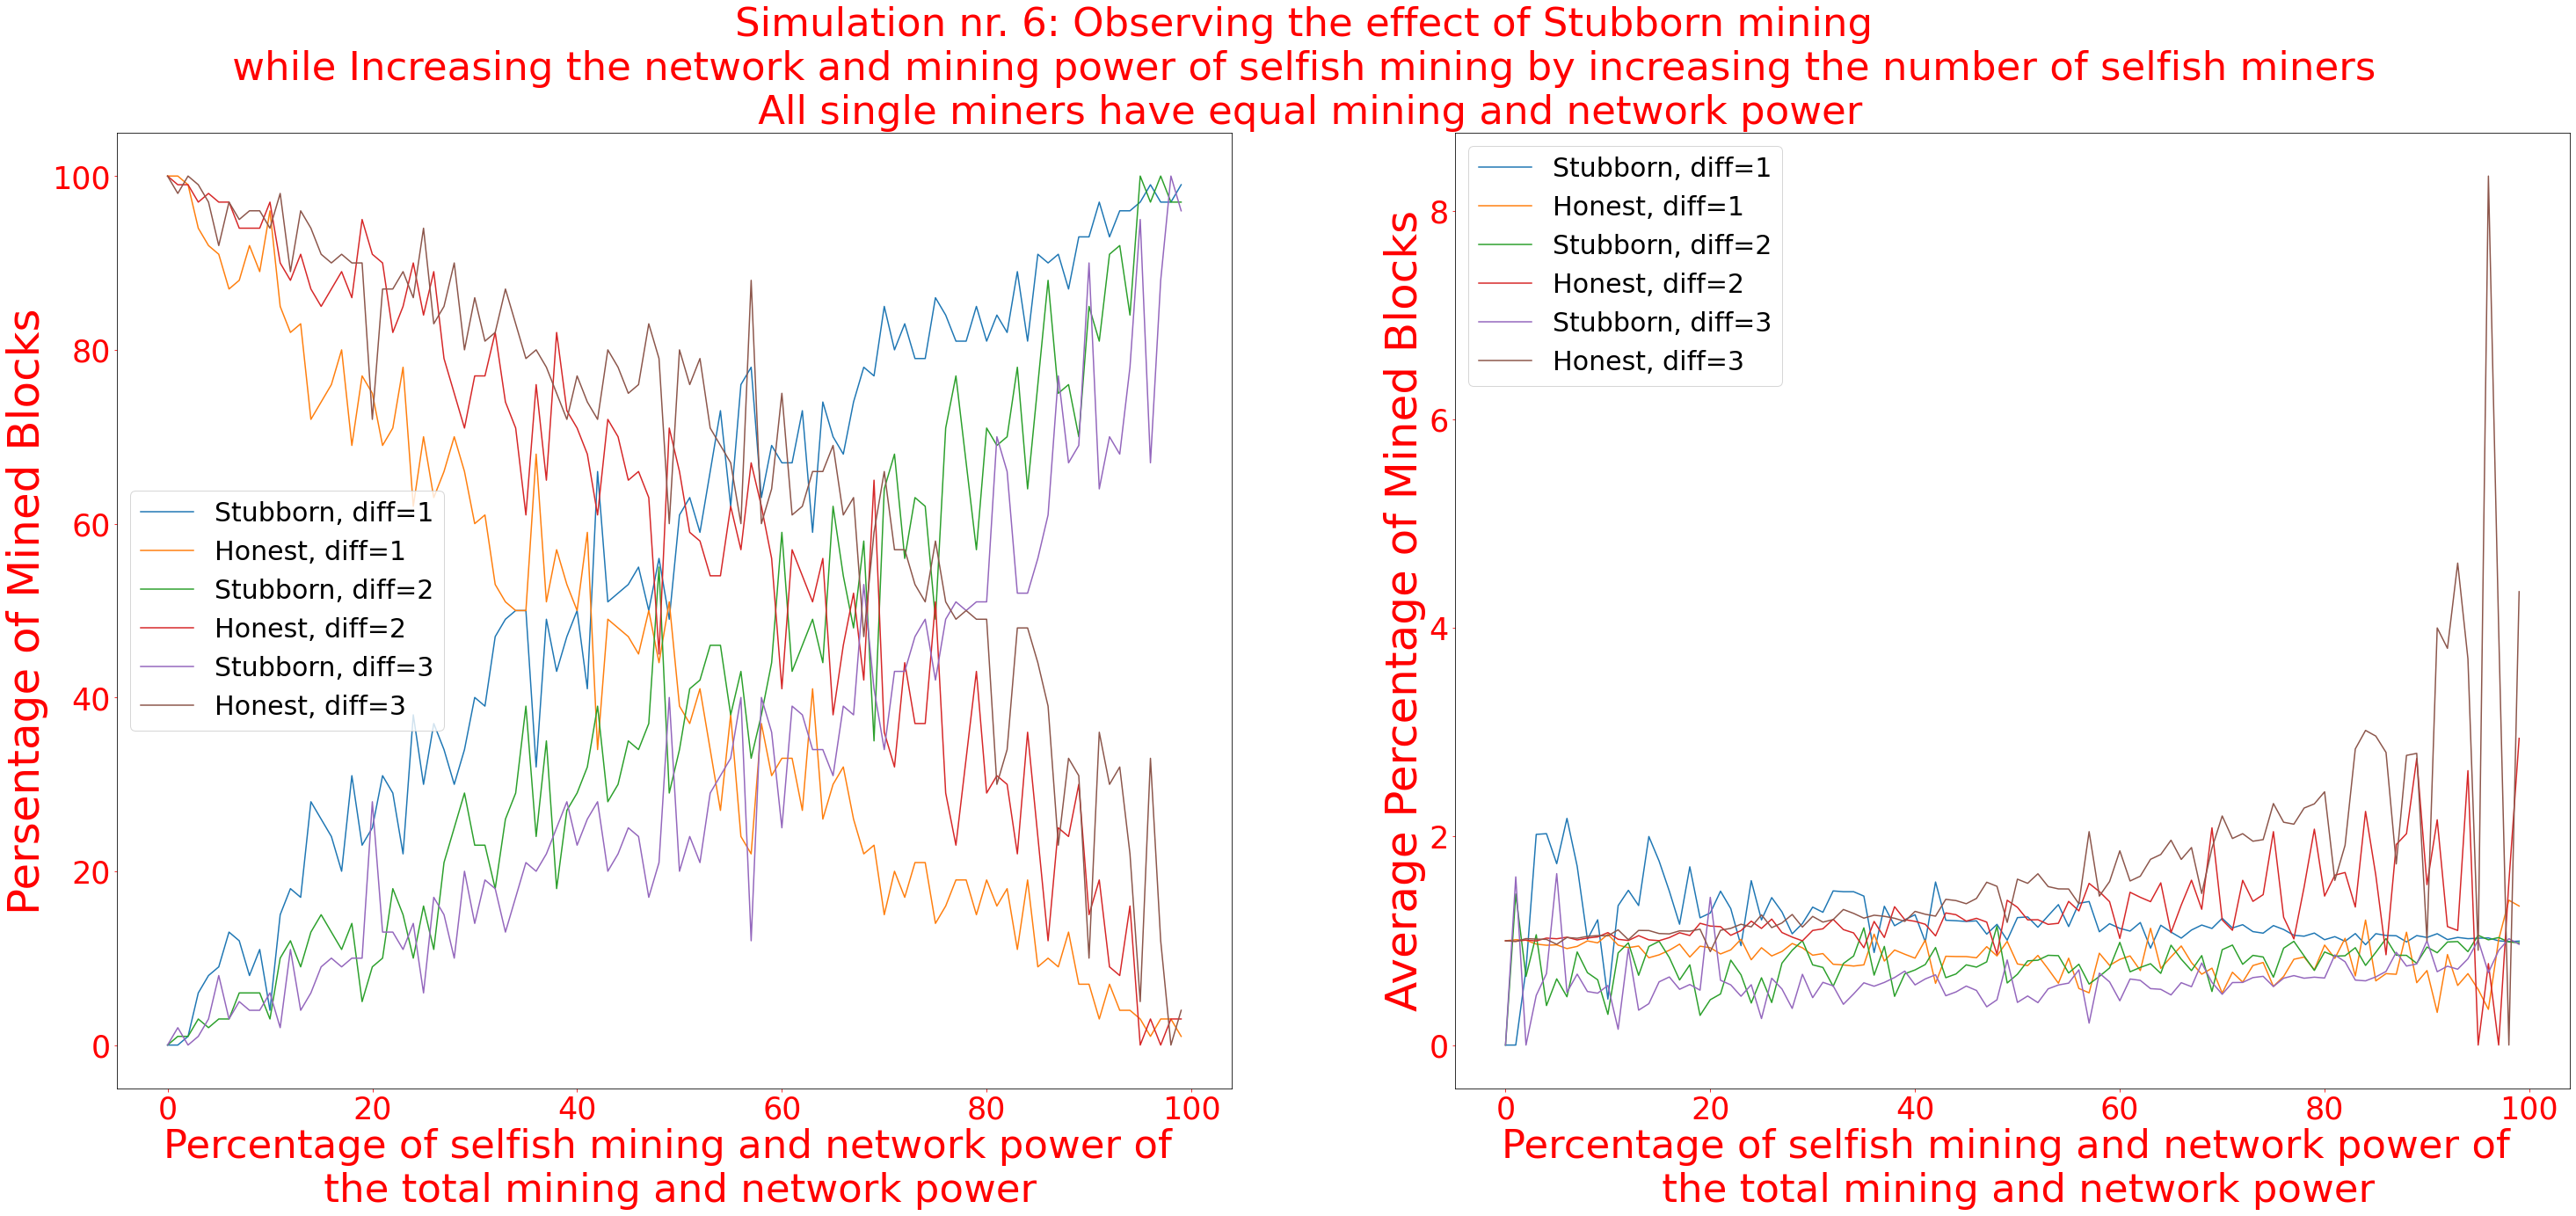

In [25]:
"""
Drawing the results of the previous simulation nr. 6
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(1, 2, figsize=(50,20))
fig.suptitle('Simulation nr. 6: Observing the effect of Stubborn mining\n while Increasing the network and mining power of selfish mining by increasing the number of selfish miners \n All single miners have equal mining and network power\n', fontsize=45).set_color('red')  

# block_difference = 1, 2, and 3
axs[0].plot(selfish_power, all_total_selfish_profits[0], label = "Stubborn, diff=1")
axs[0].plot(selfish_power, all_total_honest_profits[0], label = "Honest, diff=1")
axs[0].plot(selfish_power, all_total_selfish_profits[1], label = "Stubborn, diff=2")
axs[0].plot(selfish_power, all_total_honest_profits[1], label = "Honest, diff=2")
axs[0].plot(selfish_power, all_total_selfish_profits[2], label = "Stubborn, diff=3")
axs[0].plot(selfish_power, all_total_honest_profits[2], label = "Honest, diff=3")
axs[0].tick_params(axis='x', colors='red')
axs[0].tick_params(axis='y', colors='red')
axs[0].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[0].legend(prop={"size":30})
l = plt.setp(axs[0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0].get_yticklabels(), fontsize=35)

axs[1].plot(selfish_power, all_average_selfish_profits[0], label = "Stubborn, diff=1")
axs[1].plot(selfish_power, all_average_honest_profits[0], label = "Honest, diff=1")
axs[1].plot(selfish_power, all_average_selfish_profits[1], label = "Stubborn, diff=2")
axs[1].plot(selfish_power, all_average_honest_profits[1], label = "Honest, diff=2")
axs[1].plot(selfish_power, all_average_selfish_profits[2], label = "Stubborn, diff=3")
axs[1].plot(selfish_power, all_average_honest_profits[2], label = "Honest, diff=3")
axs[1].tick_params(axis='x', colors='red')
axs[1].tick_params(axis='y', colors='red')
axs[1].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[1].legend(prop={"size":30})
l = plt.setp(axs[1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1].get_yticklabels(), fontsize=35)


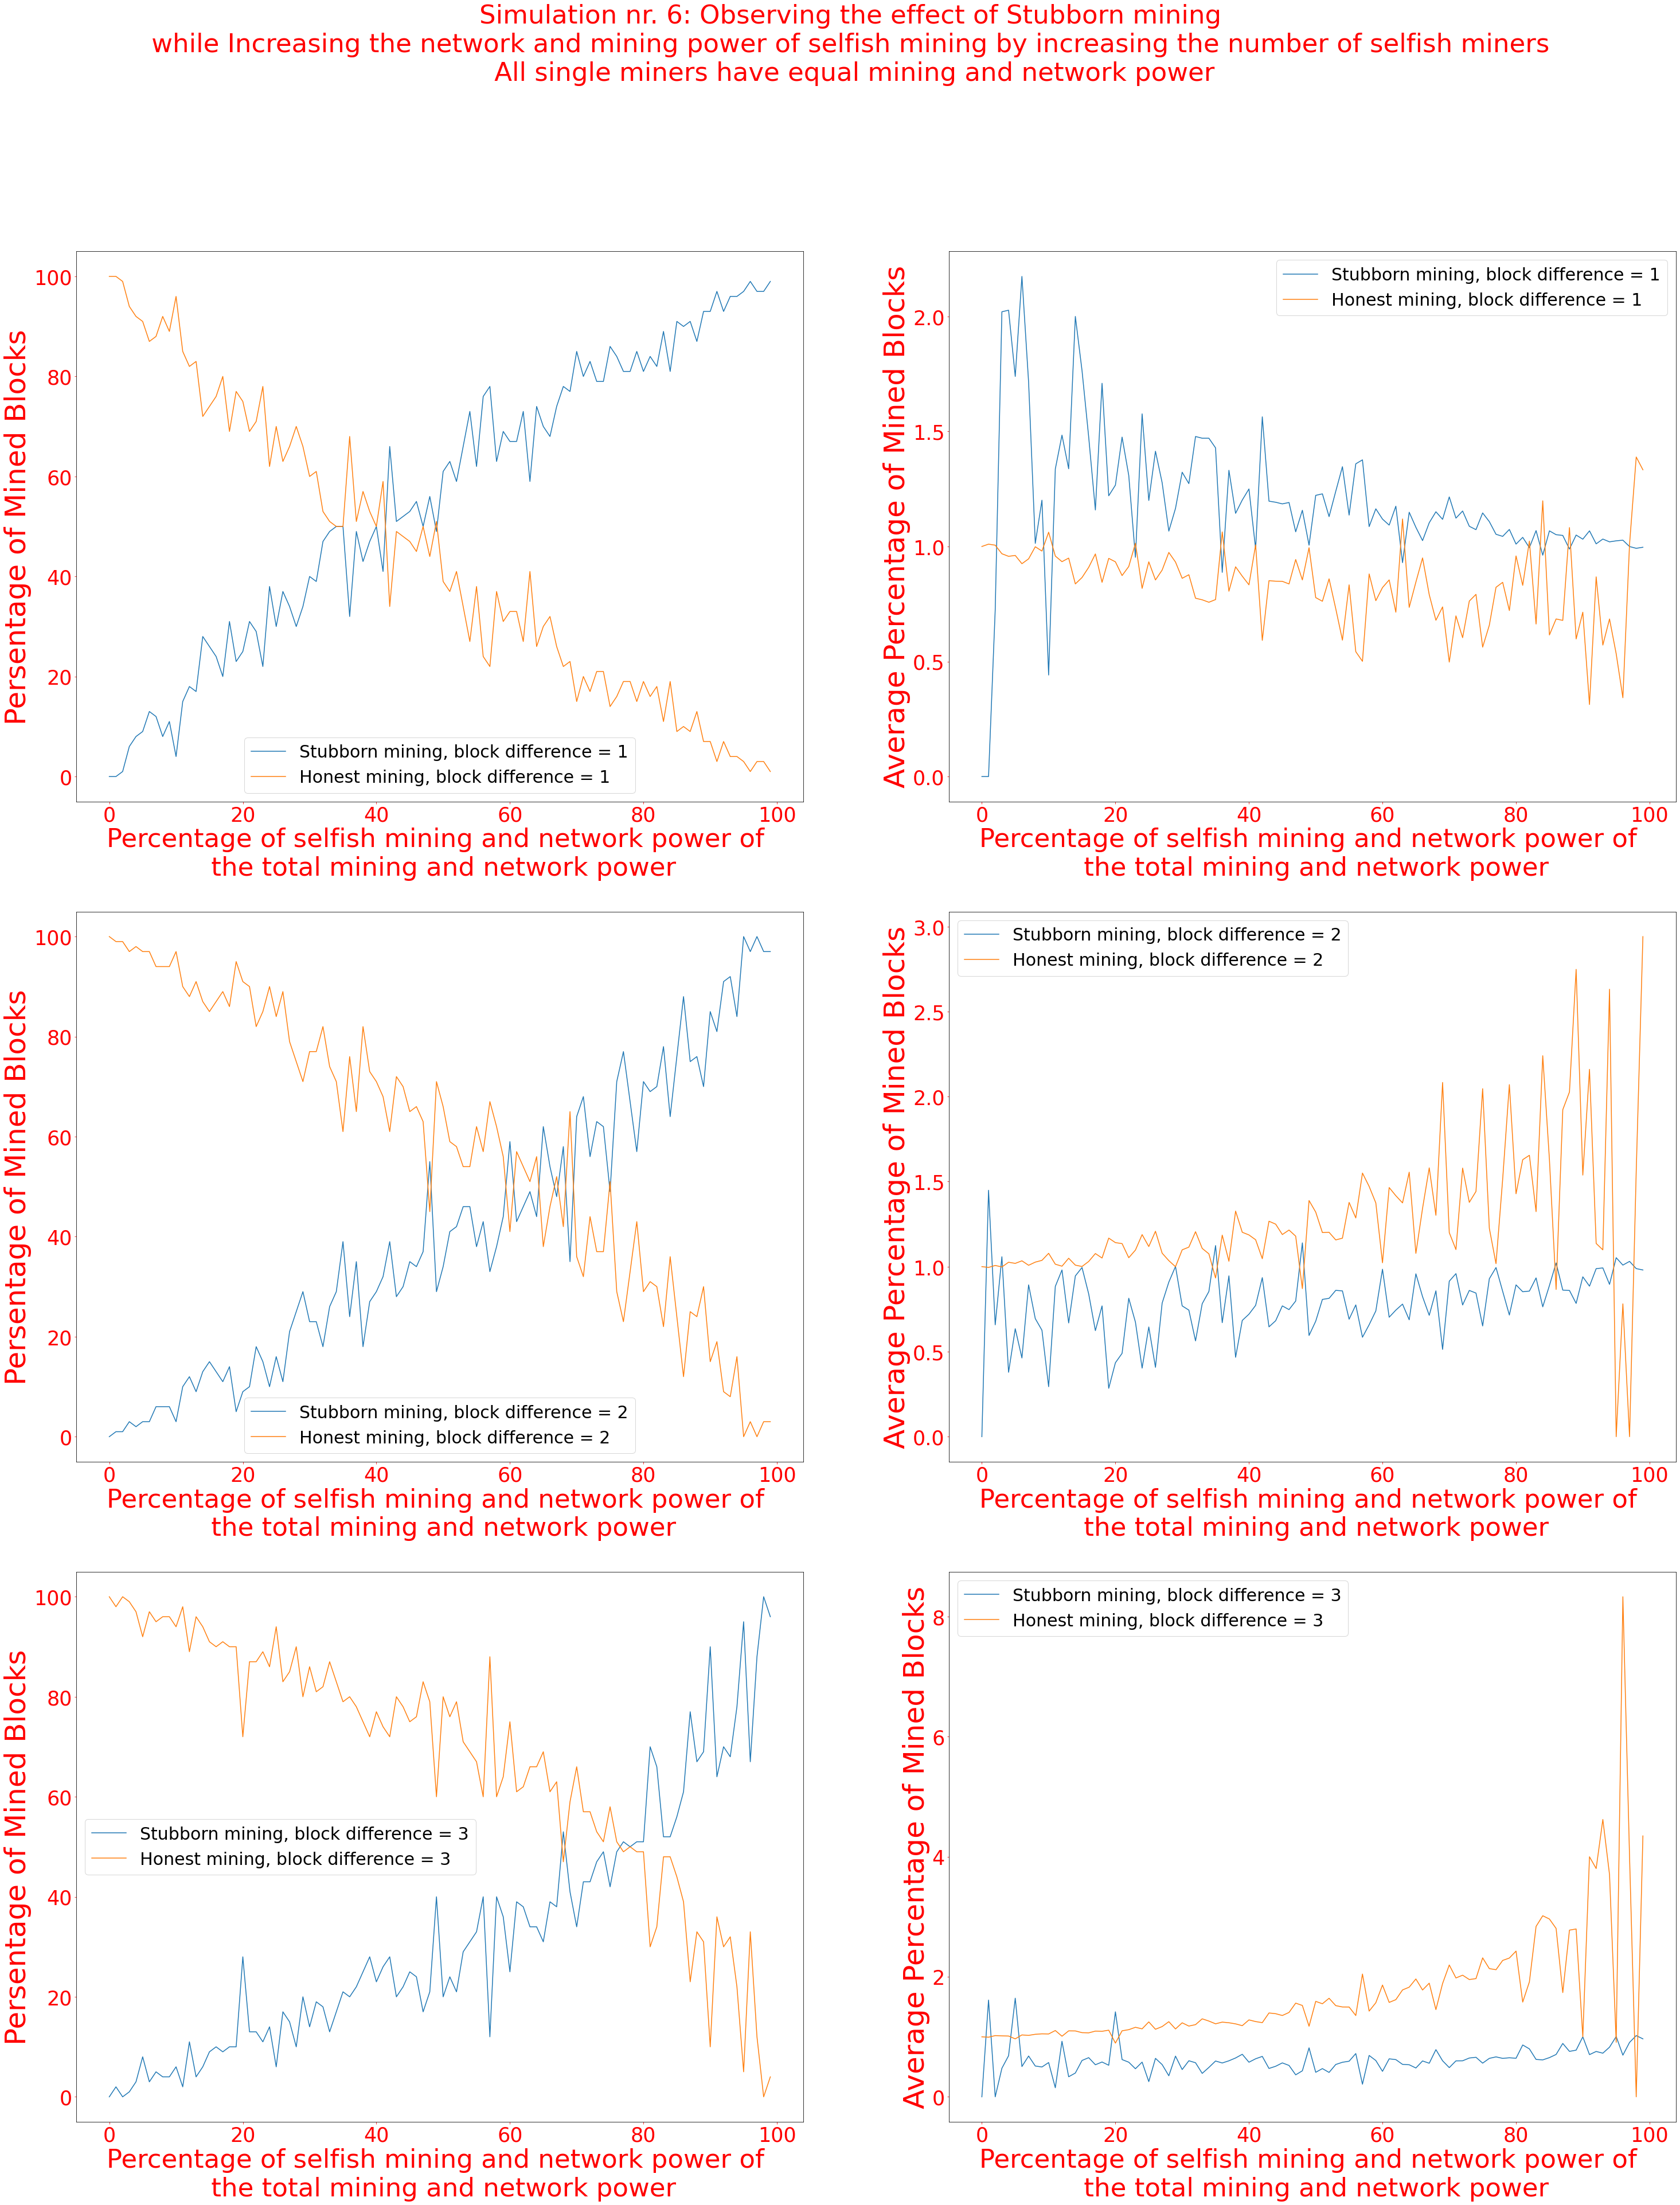

In [26]:
"""
Drawing the results of the previous simulation nr. 6
"""

import matplotlib.pyplot as plt

selfish_power = list(sim_range_selfish)
honest_power = list(sim_range_honest)

fig, axs = plt.subplots(3, 2, figsize=(50,60))
fig.suptitle('Simulation nr. 6: Observing the effect of Stubborn mining\n while Increasing the network and mining power of selfish mining by increasing the number of selfish miners \n All single miners have equal mining and network power\n', fontsize=45).set_color('red')  

# block_difference = 1
axs[0, 0].plot(selfish_power, all_total_selfish_profits[0], label = "Stubborn mining, block difference = 1")
axs[0, 0].plot(selfish_power, all_total_honest_profits[0], label = "Honest mining, block difference = 1")
axs[0, 0].tick_params(axis='x', colors='red')
axs[0, 0].tick_params(axis='y', colors='red')
axs[0, 0].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[0, 0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 0].legend(prop={"size":30})
l = plt.setp(axs[0, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 0].get_yticklabels(), fontsize=35)

axs[0, 1].plot(selfish_power, all_average_selfish_profits[0], label = "Stubborn mining, block difference = 1")
axs[0, 1].plot(selfish_power, all_average_honest_profits[0], label = "Honest mining, block difference = 1")
axs[0, 1].tick_params(axis='x', colors='red')
axs[0, 1].tick_params(axis='y', colors='red')
axs[0, 1].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[0, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[0, 1].legend(prop={"size":30})
l = plt.setp(axs[0, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[0, 1].get_yticklabels(), fontsize=35)

# block_difference = 2
axs[1, 0].plot(selfish_power, all_total_selfish_profits[1], label = "Stubborn mining, block difference = 2")
axs[1, 0].plot(selfish_power, all_total_honest_profits[1], label = "Honest mining, block difference = 2")
axs[1, 0].tick_params(axis='x', colors='red')
axs[1, 0].tick_params(axis='y', colors='red')
axs[1, 0].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[1, 0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[1, 0].legend(prop={"size":30})
l = plt.setp(axs[1, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 0].get_yticklabels(), fontsize=35)

axs[1, 1].plot(selfish_power, all_average_selfish_profits[1], label = "Stubborn mining, block difference = 2")
axs[1, 1].plot(selfish_power, all_average_honest_profits[1], label = "Honest mining, block difference = 2")
axs[1, 1].tick_params(axis='x', colors='red')
axs[1, 1].tick_params(axis='y', colors='red')
axs[1, 1].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[1, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[1, 1].legend(prop={"size":30})
l = plt.setp(axs[1, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[1, 1].get_yticklabels(), fontsize=35)

# block_difference = 3
axs[2, 0].plot(selfish_power, all_total_selfish_profits[2], label = "Stubborn mining, block difference = 3")
axs[2, 0].plot(selfish_power, all_total_honest_profits[2], label = "Honest mining, block difference = 3")
axs[2, 0].tick_params(axis='x', colors='red')
axs[2, 0].tick_params(axis='y', colors='red')
axs[2, 0].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[2, 0].set_ylabel('Persentage of Mined Blocks', fontsize=50).set_color('red')
axs[2, 0].legend(prop={"size":30})
l = plt.setp(axs[2, 0].get_xticklabels(), fontsize=35)
l = plt.setp(axs[2, 0].get_yticklabels(), fontsize=35)

axs[2, 1].plot(selfish_power, all_average_selfish_profits[2], label = "Stubborn mining, block difference = 3")
axs[2, 1].plot(selfish_power, all_average_honest_profits[2], label = "Honest mining, block difference = 3")
axs[2, 1].tick_params(axis='x', colors='red')
axs[2, 1].tick_params(axis='y', colors='red')
axs[2, 1].set_xlabel('Percentage of selfish mining and network power of \n the total mining and network power', fontsize=45).set_color('red')
axs[2, 1].set_ylabel('Average Percentage of Mined Blocks', fontsize=50).set_color('red')
axs[2, 1].legend(prop={"size":30})
l = plt.setp(axs[2, 1].get_xticklabels(), fontsize=35)
l = plt.setp(axs[2, 1].get_yticklabels(), fontsize=35)


## Analysis and Comments on Simulation Results nr. 5
When we observe the effect of the stubborn mining while inreasing the stubborn mining and network power by increasing the number of stubborn miners and decreasing the number of honest miners, we notice the following:

1. Profit of stubborn mining is increasing with increased power, and profit of honest mining is decreasing with decreased power. <br><br>

2. The higher the block difference gets, the lower the stubborn profit is.
Likewise, the higher the block difference is, the higher the honest profit is.<br><br>
	
3. All average profit are mostly between 0 and 2%, with one peak exception at 90% stubborn mining power. The exception is about 7% profit on average for 	block difference of 3 for the average honest miner.<br><br>

4. For a block difference of 1 which means we are doing just honest mining, the stubborn profit is on average higher than the average honest profit most of the time but not in total.